In [27]:
import pandas as pd
import numpy as np
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
import matplotlib.pyplot as plt
import itertools
import math
import seaborn as sns


In [28]:
# Read CSVs (adjust the file paths as needed)
crude_df = pd.read_csv('crude.csv', parse_dates=['Date'])
ho_df    = pd.read_csv('ho.csv', parse_dates=['Date'])
rbob_df  = pd.read_csv('rbob.csv', parse_dates=['Date'])

# Rename columns for clarity
crude_df.rename(columns={'F1': 'Crude_F1', 'F2': 'Crude_F2'}, inplace=True)
ho_df.rename(columns={'F1': 'HO_F1', 'F2': 'HO_F2'}, inplace=True)
rbob_df.rename(columns={'F1': 'RBOB_F1', 'F2': 'RBOB_F2'}, inplace=True)

# Scale RBOB and HO prices by multiplying by 42 to convert to dollars per barrel
rbob_df['RBOB_F1'] *= 42
rbob_df['RBOB_F2'] *= 42
ho_df['HO_F1'] *= 42
ho_df['HO_F2'] *= 42

# Merge data on 'Date'
merged = pd.merge(crude_df[['Date', 'Crude_F1', 'Crude_F2']],
                  ho_df[['Date', 'HO_F1', 'HO_F2']],
                  on='Date', how='inner')

merged = pd.merge(merged,
                  rbob_df[['Date', 'RBOB_F1', 'RBOB_F2']],
                  on='Date', how='inner')

# Sort by Date
merged.sort_values('Date', inplace=True)

# Backfill missing data
merged.fillna(method='bfill', inplace=True)

merged = merged[(merged['Date'] > '2010-01-01') & (merged['Date'] < '2023-12-29')]

merged.head()

<ipython-input-28-f20190460eb7>:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged.fillna(method='bfill', inplace=True)


,Date,Crude_F1,Crude_F2,HO_F1,HO_F2,RBOB_F1,RBOB_F2
1067,2010-01-04,81.51,82.12,92.022,92.106,88.368,89.040
1068,2010-01-05,81.77,82.41,92.148,92.442,89.250,89.754
1069,2010-01-06,83.18,83.75,92.526,92.988,89.754,90.384
1070,2010-01-07,82.66,83.19,91.728,92.190,89.670,90.258
1071,2010-01-08,82.75,83.30,92.400,92.694,90.510,90.930


In [29]:
expiry_df = pd.read_excel('Expiration.xlsx')

expiry_df = expiry_df.loc[:, ~expiry_df.columns.str.contains('^Unnamed')]
expiry_df['WTI'] = pd.to_datetime(expiry_df['WTI'])
expiry_df['RBOB'] = pd.to_datetime(expiry_df['RBOB'])

expiry_df.head()

,WTI,RBOB
0,2005-12-20,2005-12-30
1,2006-01-20,2006-01-31
2,2006-02-21,2006-02-28
3,2006-03-21,2006-03-31
4,2006-04-20,2006-04-28


In [30]:
# Expiry mapping for WTI, HO, and RBOB
merged['Expiry_WTI'] = np.where(merged['Date'].isin(expiry_df['WTI']), 'Expiry', None)
merged['Expiry_RBOB'] = np.where(merged['Date'].isin(expiry_df['RBOB']), 'Expiry', None)
merged['Expiry_HO'] = np.where(merged['Date'].isin(expiry_df['RBOB']), 'Expiry', None)  # Same expiry as RBOB

# Roll mapping (5 rows before expiry) for WTI, HO, and RBOB
merged['Roll_WTI'] = np.nan
merged['Roll_RBOB'] = np.nan
merged['Roll_HO'] = np.nan

for i in range(5, len(merged)):
    if merged.loc[merged.index[i], 'Expiry_WTI'] == 'Expiry':
        merged.loc[merged.index[i-5], 'Roll_WTI'] = 'Roll'
    if merged.loc[merged.index[i], 'Expiry_RBOB'] == 'Expiry':
        merged.loc[merged.index[i-5], 'Roll_RBOB'] = 'Roll'
    if merged.loc[merged.index[i], 'Expiry_HO'] == 'Expiry':
        merged.loc[merged.index[i-5], 'Roll_HO'] = 'Roll'

# Active contract column for WTI, HO, and RBOB
merged['Active_Contract_WTI'] = 'F1'
merged['Active_Contract_RBOB'] = 'F1'
merged['Active_Contract_HO'] = 'F1'

for i in range(1, len(merged)):
    # WTI Active Contract
    if merged.loc[merged.index[i], 'Roll_WTI'] == 'Roll':
        merged.loc[merged.index[i]:, 'Active_Contract_WTI'] = 'F2'
    if merged.loc[merged.index[i], 'Expiry_WTI'] == 'Expiry' and i + 1 < len(merged):
        merged.loc[merged.index[i + 1]:, 'Active_Contract_WTI'] = 'F1'

    # RBOB follows WTI for rolling together
    if merged.loc[merged.index[i], 'Roll_RBOB'] == 'Roll':
        merged.loc[merged.index[i]:, 'Active_Contract_RBOB'] = 'F2'
    if merged.loc[merged.index[i], 'Expiry_RBOB'] == 'Expiry' and i + 1 < len(merged):
        merged.loc[merged.index[i + 1]:, 'Active_Contract_RBOB'] = 'F1'

    # HO Active Contract
    if merged.loc[merged.index[i], 'Roll_HO'] == 'Roll':
        merged.loc[merged.index[i]:, 'Active_Contract_HO'] = 'F2'
    if merged.loc[merged.index[i], 'Expiry_HO'] == 'Expiry' and i + 1 < len(merged):
        merged.loc[merged.index[i + 1]:, 'Active_Contract_HO'] = 'F1'

# P&L Calculation for WTI, RBOB, and HO
merged['Roll_Expiry_PnL_WTI'] = np.nan
merged['Roll_Expiry_PnL_RBOB'] = np.nan
merged['Roll_Expiry_PnL_HO'] = np.nan

merged['Daily_PnL_WTI'] = np.nan
merged['Daily_PnL_RBOB'] = np.nan
merged['Daily_PnL_HO'] = np.nan

for i in range(1, len(merged)):
    # Roll & Expiry PnL for WTI
    if merged.loc[merged.index[i], 'Roll_WTI'] == 'Roll':
        merged.loc[merged.index[i], 'Roll_Expiry_PnL_WTI'] = (
            merged.loc[merged.index[i], 'Crude_F1'] - merged.loc[merged.index[i - 1], 'Crude_F1']
        )
    if merged.loc[merged.index[i], 'Expiry_WTI'] == 'Expiry' and i + 1 < len(merged):
        merged.loc[merged.index[i + 1], 'Roll_Expiry_PnL_WTI'] = (
            merged.loc[merged.index[i + 1], 'Crude_F1'] - merged.loc[merged.index[i], 'Crude_F2']
        )

    # Roll & Expiry PnL for RBOB
    if merged.loc[merged.index[i], 'Roll_RBOB'] == 'Roll':
        merged.loc[merged.index[i], 'Roll_Expiry_PnL_RBOB'] = (
            merged.loc[merged.index[i], 'RBOB_F1'] - merged.loc[merged.index[i - 1], 'RBOB_F1']
        )
    if merged.loc[merged.index[i], 'Expiry_RBOB'] == 'Expiry' and i + 1 < len(merged):
        merged.loc[merged.index[i + 1], 'Roll_Expiry_PnL_RBOB'] = (
            merged.loc[merged.index[i + 1], 'RBOB_F1'] - merged.loc[merged.index[i], 'RBOB_F2']
        )

    # Roll & Expiry PnL for HO
    if merged.loc[merged.index[i], 'Roll_HO'] == 'Roll':
        merged.loc[merged.index[i], 'Roll_Expiry_PnL_HO'] = (
            merged.loc[merged.index[i], 'HO_F1'] - merged.loc[merged.index[i - 1], 'HO_F1']
        )
    if merged.loc[merged.index[i], 'Expiry_HO'] == 'Expiry' and i + 1 < len(merged):
        merged.loc[merged.index[i + 1], 'Roll_Expiry_PnL_HO'] = (
            merged.loc[merged.index[i + 1], 'HO_F1'] - merged.loc[merged.index[i], 'HO_F2']
        )

    # Daily PnL for WTI
    if merged.loc[merged.index[i], 'Roll_WTI'] == 'Roll':  # Zero PnL on Roll day
        merged.loc[merged.index[i], 'Daily_PnL_WTI'] = 0
    elif merged.loc[merged.index[i - 1], 'Expiry_WTI'] == 'Expiry':  # Zero PnL the day after Expiry
        merged.loc[merged.index[i], 'Daily_PnL_WTI'] = 0
    else:
        if merged.loc[merged.index[i], 'Active_Contract_WTI'] == 'F1':
            merged.loc[merged.index[i], 'Daily_PnL_WTI'] = (
                merged.loc[merged.index[i], 'Crude_F1'] - merged.loc[merged.index[i - 1], 'Crude_F1']
            )
        else:
            merged.loc[merged.index[i], 'Daily_PnL_WTI'] = (
                merged.loc[merged.index[i], 'Crude_F2'] - merged.loc[merged.index[i - 1], 'Crude_F2']
            )

    # Daily PnL for RBOB
    if merged.loc[merged.index[i], 'Roll_RBOB'] == 'Roll':  # Zero PnL on Roll day
        merged.loc[merged.index[i], 'Daily_PnL_RBOB'] = 0
    elif merged.loc[merged.index[i - 1], 'Expiry_RBOB'] == 'Expiry':  # Zero PnL the day after Expiry
        merged.loc[merged.index[i], 'Daily_PnL_RBOB'] = 0
    else:
        if merged.loc[merged.index[i], 'Active_Contract_RBOB'] == 'F1':
            merged.loc[merged.index[i], 'Daily_PnL_RBOB'] = (
                merged.loc[merged.index[i], 'RBOB_F1'] - merged.loc[merged.index[i - 1], 'RBOB_F1']
            )
        else:
            merged.loc[merged.index[i], 'Daily_PnL_RBOB'] = (
                merged.loc[merged.index[i], 'RBOB_F2'] - merged.loc[merged.index[i - 1], 'RBOB_F2']
            )

    # Daily PnL for HO
    if merged.loc[merged.index[i], 'Roll_HO'] == 'Roll':  # Zero PnL on Roll day
        merged.loc[merged.index[i], 'Daily_PnL_HO'] = 0
    elif merged.loc[merged.index[i - 1], 'Expiry_HO'] == 'Expiry':  # Zero PnL the day after Expiry
        merged.loc[merged.index[i], 'Daily_PnL_HO'] = 0
    else:
        if merged.loc[merged.index[i], 'Active_Contract_HO'] == 'F1':
            merged.loc[merged.index[i], 'Daily_PnL_HO'] = (
                merged.loc[merged.index[i], 'HO_F1'] - merged.loc[merged.index[i - 1], 'HO_F1']
            )
        else:
            merged.loc[merged.index[i], 'Daily_PnL_HO'] = (
                merged.loc[merged.index[i], 'HO_F2'] - merged.loc[merged.index[i - 1], 'HO_F2']
            )

# Total Daily PnL per Barrel for WTI, RBOB, and HO
merged['Total_Daily_PnL_WTI'] = merged['Roll_Expiry_PnL_WTI'].fillna(0) + merged['Daily_PnL_WTI'].fillna(0)
merged['Total_Daily_PnL_RBOB'] = merged['Roll_Expiry_PnL_RBOB'].fillna(0) + merged['Daily_PnL_RBOB'].fillna(0)
merged['Total_Daily_PnL_HO'] = merged['Roll_Expiry_PnL_HO'].fillna(0) + merged['Daily_PnL_HO'].fillna(0)



<ipython-input-30-aab8f158c586>:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Roll' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  merged.loc[merged.index[i-5], 'Roll_WTI'] = 'Roll'
<ipython-input-30-aab8f158c586>:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Roll' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  merged.loc[merged.index[i-5], 'Roll_RBOB'] = 'Roll'
<ipython-input-30-aab8f158c586>:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Roll' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  merged.loc[merged.index[i-5], 'Roll_HO'] = 'Roll'


In [31]:
merged.to_csv('merged.csv', index=False)

In [51]:
import numpy as np
import pandas as pd
import math
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts

# 1. Engle-Granger Cointegration Test Function
def engle_granger_test(y, x):
    result = sm.OLS(y, sm.add_constant(x)).fit()
    resid = result.resid
    adf_pval = ts.adfuller(resid)[1]  # Extracting p-value from ADF test
    return adf_pval

global_sharpe_ratio = None
# 2. Strategy Function with Performance Metrics
def run_pair_trading_strategy(merged, asset1, asset2, beta_window=30, z_window=60, z_threshold=1.5):
    # Dynamically select the columns for asset1 and asset2 (Crude, HO, or RBOB)
    asset1_f1 = f'{asset1}_F1'
    asset2_f1 = f'{asset2}_F1'

    # Engle-Granger Cointegration Test
    pvalue = engle_granger_test(merged[asset1_f1], merged[asset2_f1])
    print(f"Engle-Granger p-value: {pvalue}")

    if pvalue >= 0.05:
        print("Pair not cointegrated. Stop here or try another pair.")
        return
    else:
        print("Pair cointegrated. Proceeding with rolling beta.")


    # 4. Rolling Beta
    merged['Rolling_Beta'] = (
        merged[asset1_f1].rolling(window=beta_window).cov(merged[asset2_f1])
        / merged[asset2_f1].rolling(window=beta_window).var()
    )

    # 5. Compute Spread
    merged['Spread'] = merged[asset1_f1] - merged['Rolling_Beta'] * merged[asset2_f1]

    # 6. Compute Rolling Mean, Std, and Z-score (60-day window or the z_window given)
    merged['Spread_Mean'] = merged['Spread'].rolling(window=z_window).mean()
    merged['Spread_Std'] = merged['Spread'].rolling(window=z_window).std()
    merged['Z_Score'] = (merged['Spread'] - merged['Spread_Mean']) / merged['Spread_Std']

    # 7. Generate Trading Signals (Enter at Z > z_threshold short, Z < -z_threshold long; Exit when Z crosses zero)
    merged['Position'] = 0  # Initialize position column

    for i in range(1, len(merged)):
        if merged['Z_Score'].iloc[i] > z_threshold:
            merged.at[merged.index[i], 'Position'] = -1  # Short Spread
        elif merged['Z_Score'].iloc[i] < -z_threshold:
            merged.at[merged.index[i], 'Position'] = 1   # Long Spread
        elif merged['Position'].iloc[i-1] == 1 and merged['Z_Score'].iloc[i] >= 0:
            merged.at[merged.index[i], 'Position'] = 0   # Close Long
        elif merged['Position'].iloc[i-1] == -1 and merged['Z_Score'].iloc[i] <= 0:
            merged.at[merged.index[i], 'Position'] = 0   # Close Short
        else:
            merged.at[merged.index[i], 'Position'] = merged['Position'].iloc[i-1]  # Hold previous position

    scaling_factor = 10 * 1000

    # 8. Calculate PnL (Using Previous Signal to Avoid Bias)
    merged['Spread_Return'] = merged['Spread'].diff()  # Daily change in spread
    merged['Strategy_Return'] = merged['Position'].shift(1) * merged['Spread_Return']  # Previous day's position * today's return

    # Scale the strategy return
    merged['Scaled_Strategy_Return'] = merged['Strategy_Return'] * scaling_factor

    # 9. Compute Cumulative PnL (Using the Scaled Strategy Return)
    merged['Cumulative_PnL'] = merged['Scaled_Strategy_Return'].cumsum()

    # 10. Calculate APL (Annualized PnL)
    total_pnl = merged['Scaled_Strategy_Return'].sum()  # Sum of strategy returns using the scaled return
    days_in_dataset = len(merged)
    APL = total_pnl / (days_in_dataset / 252)  # Annualized PnL

    # 11. Calculate Sharpe Ratio
    daily_std = merged['Strategy_Return'].std()
    global_sharpe_ratio = APL / (daily_std * math.sqrt(250) * scaling_factor)  # Assume 250 trading days in a year

    # Compute Cumulative Rolling PnL using the scaled return
    merged['Rolling_Cumulative_PnL'] = merged['Scaled_Strategy_Return'].cumsum()

    # 12. Calculate Highest Maximum Value of Cumulative PnL (HMW)
    merged['Rolling_HMW'] = merged['Rolling_Cumulative_PnL'].cummax()  # Highest Maximum Value (Cumulative PnL)

    # 13. Calculate Drawdown (DD)
    merged['Rolling_Drawdown'] = merged['Rolling_Cumulative_PnL'] - merged['Rolling_HMW']  # Negative drawdown

    # 14. Calculate Maximum Drawdown (Max DD)
    max_dd = merged['Rolling_Drawdown'].min()  # Minimum of Drawdown column gives Max Drawdown

    # 15. Calculate RoD (Return on Drawdown)
    RoD = APL / abs(max_dd)

    # Display metrics
    metrics = {
        "APL": APL,
        "Sharpe Ratio": global_sharpe_ratio,
        "Max Drawdown": max_dd,
        "RoD": RoD
    }

    print("Performance Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    # Plotting the Cumulative PnL and Rolling Drawdown
    plt.figure(figsize=(10, 6))

    # Plot Cumulative PnL
    plt.plot(merged['Date'], merged['Rolling_Cumulative_PnL'], label='Cumulative Rolling PnL', color='blue')

    # Plot Rolling Drawdown
    plt.fill_between(merged['Date'], merged['Rolling_Drawdown'], color='orange', alpha=0.5, label='Rolling Drawdown')

    # Add labels and title
    plt.title('Cumulative Rolling PnL and Rolling Drawdown')
    plt.xlabel('Date')
    plt.ylabel('Amount ($)')
    plt.legend(loc='upper left')

    # Show the plot
    plt.tight_layout()
    plt.show()


    return merged

#**Gridsearch**

In [53]:
def optimize_sharpe_ratio(merged, asset1, asset2, beta_windows, z_thresholds):
    best_sharpe = -float('inf')
    best_params = None
    results = []
    sharpe_matrix = pd.DataFrame(index=beta_windows, columns=z_thresholds)

    # Iterate over all parameter combinations
    for beta_window, z_threshold in itertools.product(beta_windows, z_thresholds):
        print(f"Testing beta_window={beta_window}, z_threshold={z_threshold}")

        # Run strategy with current parameters
        modified_merged = run_pair_trading_strategy(merged.copy(), asset1, asset2, beta_window, 60, z_threshold)

        if modified_merged is None:
            continue  # Skip if no trades are made (e.g., no cointegration)

        # Compute APL (Annualized PnL) with the scaling factor
        # Use the scaled strategy returns for APL
        scaling_factor = 10 * 1000
        total_pnl = modified_merged['Scaled_Strategy_Return'].sum()  # Sum of strategy returns using the scaled return
        days_in_dataset = len(modified_merged)
        APL = total_pnl / (days_in_dataset / 252)  # Annualized PnL (scaling factor already considered in the returns)

        # Compute Sharpe Ratio using the scaled returns
        daily_std = modified_merged['Strategy_Return'].std()
        sharpe_ratio = APL / (daily_std * math.sqrt(250)*scaling_factor)  # Consistent Sharpe Ratio calculation (scaled)


        results.append((beta_window, z_threshold, sharpe_ratio))
        sharpe_matrix.loc[beta_window, z_threshold] = sharpe_ratio

        # Track the best Sharpe Ratio
        if sharpe_ratio > best_sharpe:
            best_sharpe = sharpe_ratio
            best_params = (beta_window, z_threshold)

    # Print results
    print("Best Parameters:", best_params, "Best Sharpe Ratio:", best_sharpe)

    # Convert sharpe_matrix to float for heatmap plotting
    sharpe_matrix = sharpe_matrix.astype(float)

    # Plot heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(sharpe_matrix, annot=True, cmap="Greens", linewidths=0.5, fmt=".2f")
    plt.xlabel("Z-Threshold")
    plt.ylabel("Beta Window")
    plt.title("Sharpe Ratio Heatmap")
    plt.show()

    return results, best_params


# **Heatmap Crude-RBOB**

Testing beta_window=20, z_threshold=1.5
Engle-Granger p-value: 7.771103183304112e-06
Pair cointegrated. Proceeding with rolling beta.
Performance Metrics:
APL: 1891590.0027
Sharpe Ratio: 2.0636
Max Drawdown: -1418981.5740
RoD: 1.3331


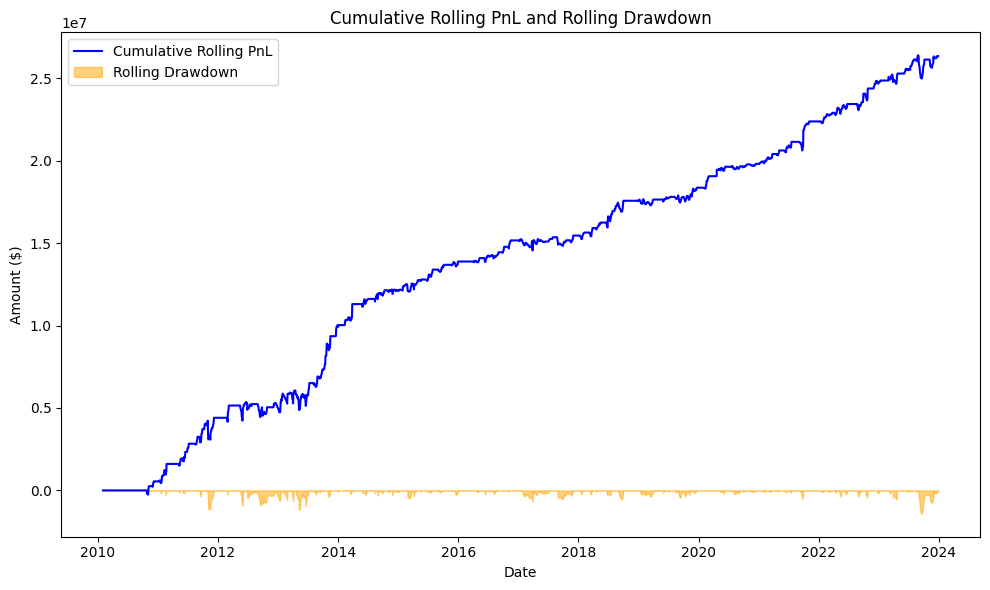

Testing beta_window=20, z_threshold=2.0
Engle-Granger p-value: 7.771103183304112e-06
Pair cointegrated. Proceeding with rolling beta.
Performance Metrics:
APL: 1456118.6638
Sharpe Ratio: 1.8992
Max Drawdown: -1418981.5740
RoD: 1.0262


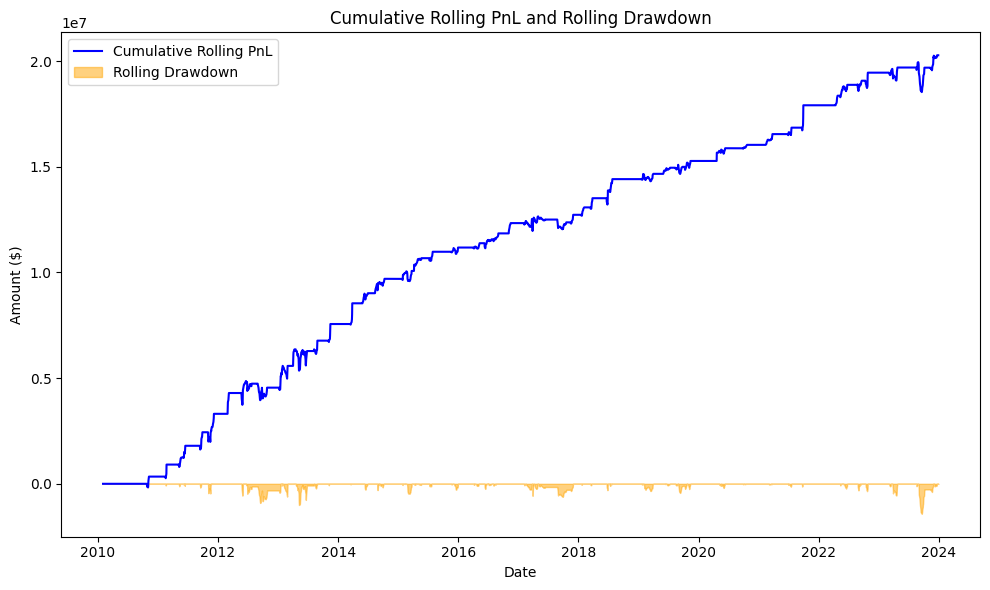

Testing beta_window=20, z_threshold=2.5
Engle-Granger p-value: 7.771103183304112e-06
Pair cointegrated. Proceeding with rolling beta.
Performance Metrics:
APL: 709180.3951
Sharpe Ratio: 1.2629
Max Drawdown: -1418981.5740
RoD: 0.4998


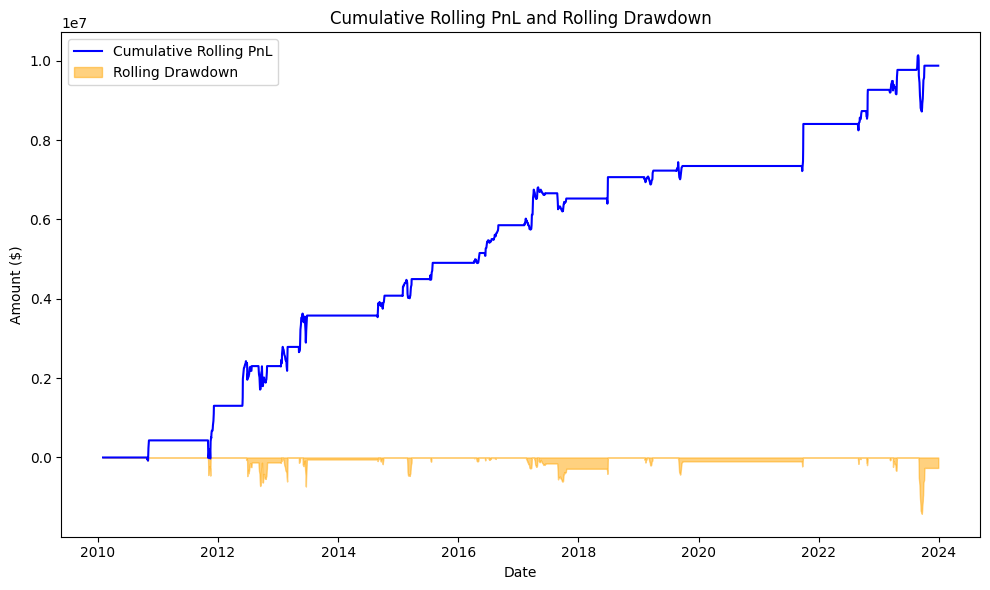

Testing beta_window=20, z_threshold=3.0
Engle-Granger p-value: 7.771103183304112e-06
Pair cointegrated. Proceeding with rolling beta.
Performance Metrics:
APL: 315221.7364
Sharpe Ratio: 0.8258
Max Drawdown: -908099.0488
RoD: 0.3471


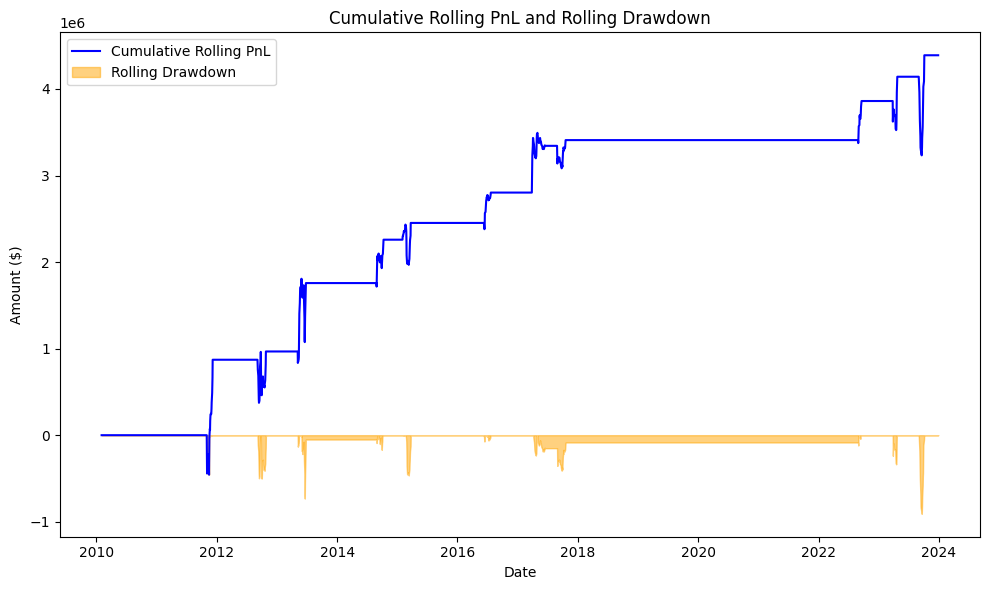

Testing beta_window=30, z_threshold=1.5
Engle-Granger p-value: 7.771103183304112e-06
Pair cointegrated. Proceeding with rolling beta.
Performance Metrics:
APL: 784471.5589
Sharpe Ratio: 1.2677
Max Drawdown: -1389355.2982
RoD: 0.5646


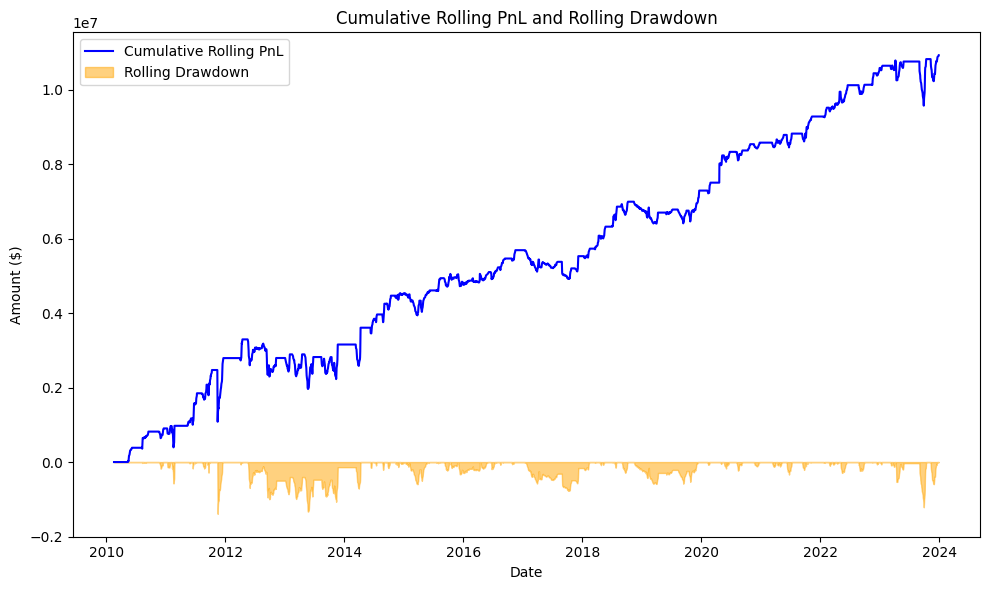

Testing beta_window=30, z_threshold=2.0
Engle-Granger p-value: 7.771103183304112e-06
Pair cointegrated. Proceeding with rolling beta.
Performance Metrics:
APL: 694759.5769
Sharpe Ratio: 1.2356
Max Drawdown: -1389355.2982
RoD: 0.5001


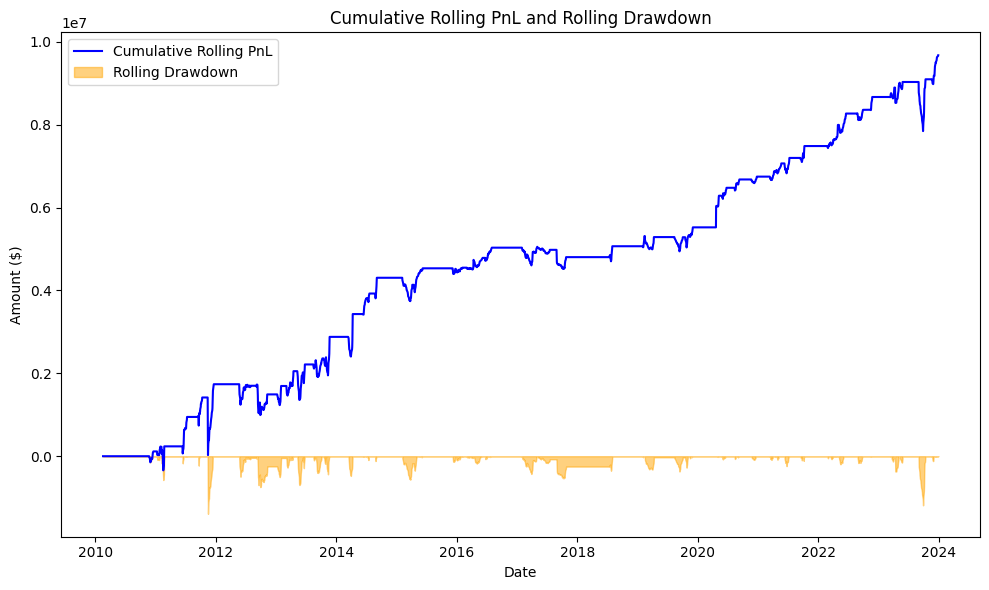

Testing beta_window=30, z_threshold=2.5
Engle-Granger p-value: 7.771103183304112e-06
Pair cointegrated. Proceeding with rolling beta.
Performance Metrics:
APL: 375817.0185
Sharpe Ratio: 0.7920
Max Drawdown: -1389355.2982
RoD: 0.2705


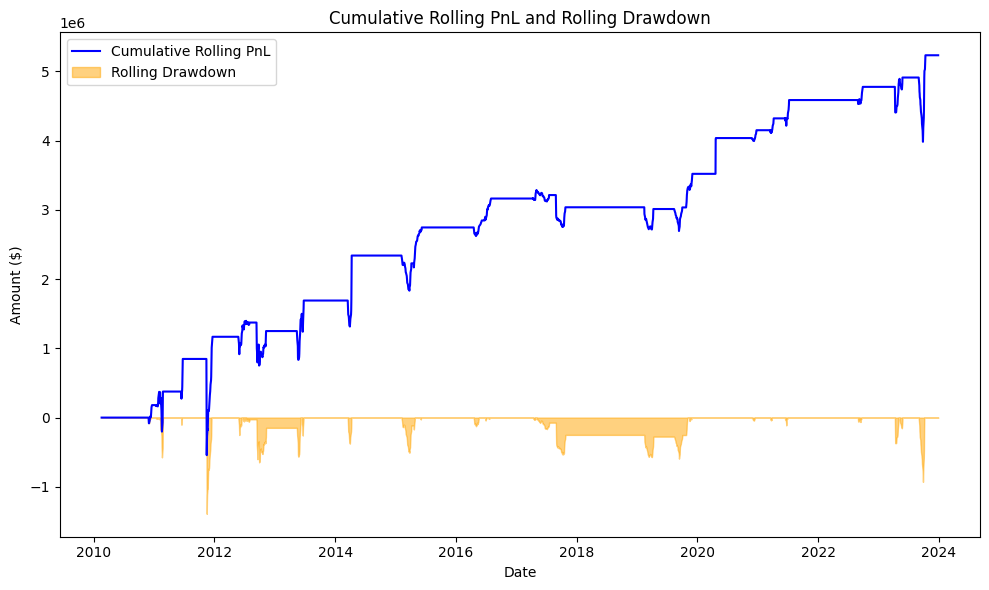

Testing beta_window=30, z_threshold=3.0
Engle-Granger p-value: 7.771103183304112e-06
Pair cointegrated. Proceeding with rolling beta.
Performance Metrics:
APL: 279267.7697
Sharpe Ratio: 0.7795
Max Drawdown: -928311.2091
RoD: 0.3008


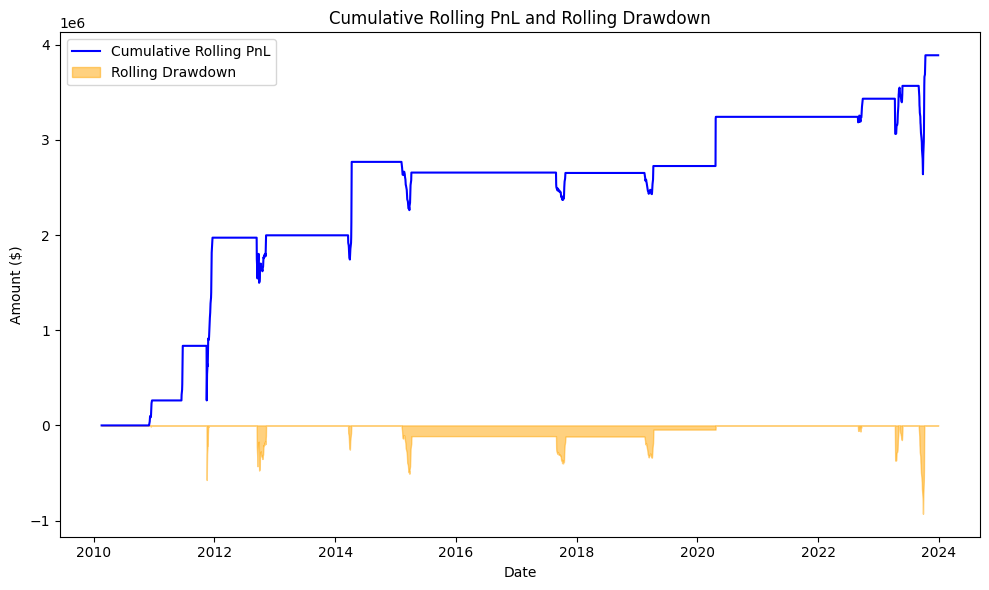

Testing beta_window=40, z_threshold=1.5
Engle-Granger p-value: 7.771103183304112e-06
Pair cointegrated. Proceeding with rolling beta.
Performance Metrics:
APL: 375404.2414
Sharpe Ratio: 0.7232
Max Drawdown: -1651230.4729
RoD: 0.2273


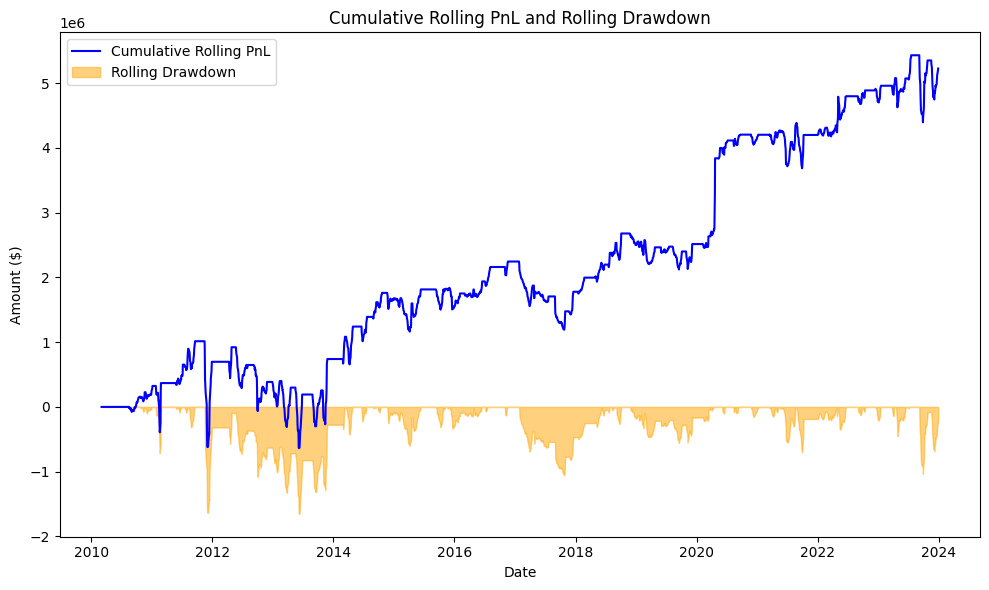

Testing beta_window=40, z_threshold=2.0
Engle-Granger p-value: 7.771103183304112e-06
Pair cointegrated. Proceeding with rolling beta.
Performance Metrics:
APL: 445028.9686
Sharpe Ratio: 0.9960
Max Drawdown: -1294083.3620
RoD: 0.3439


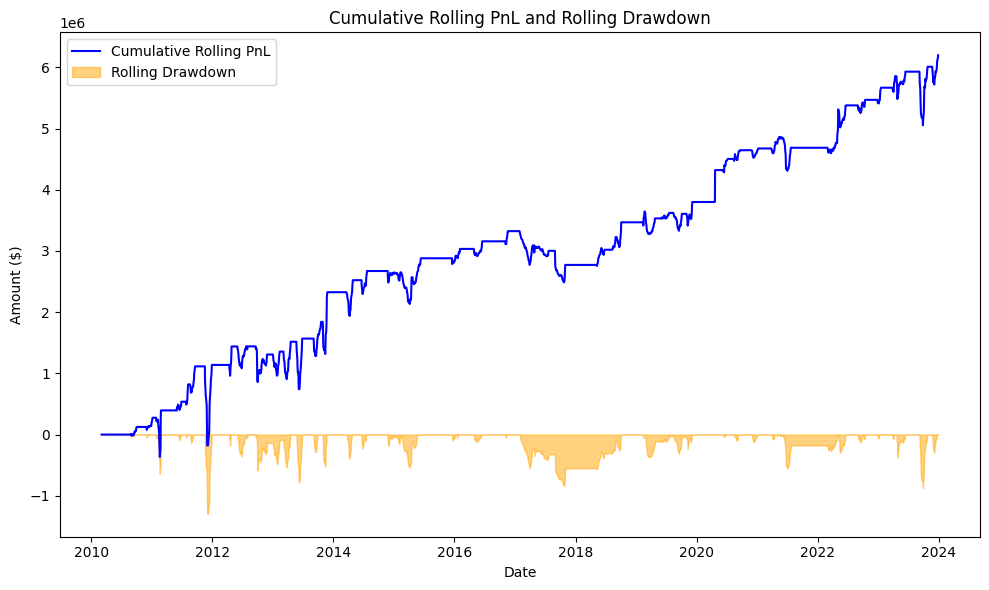

Testing beta_window=40, z_threshold=2.5
Engle-Granger p-value: 7.771103183304112e-06
Pair cointegrated. Proceeding with rolling beta.
Performance Metrics:
APL: 341902.0373
Sharpe Ratio: 0.8881
Max Drawdown: -1294083.3620
RoD: 0.2642


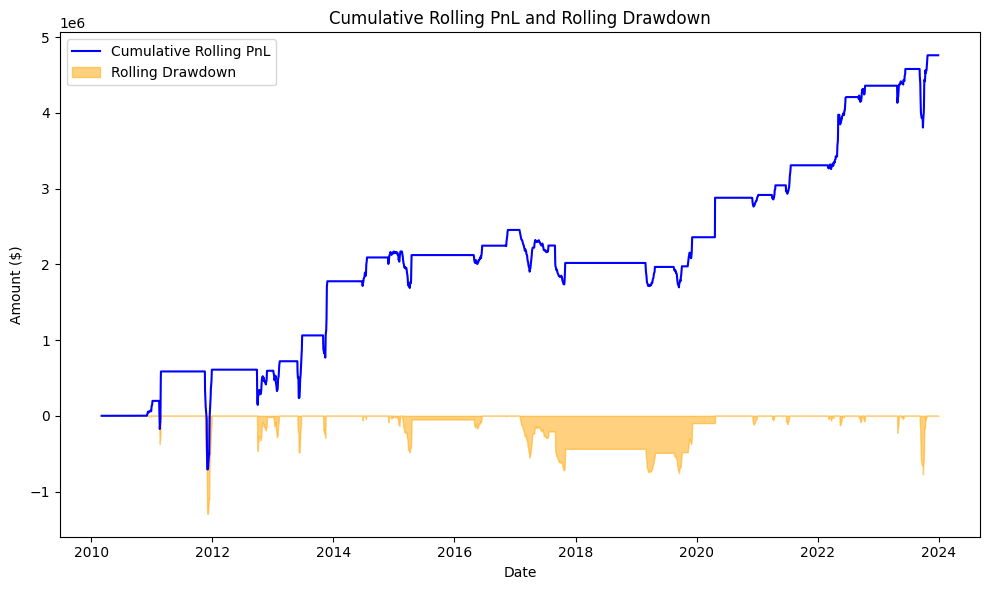

Testing beta_window=40, z_threshold=3.0
Engle-Granger p-value: 7.771103183304112e-06
Pair cointegrated. Proceeding with rolling beta.
Performance Metrics:
APL: 219540.8285
Sharpe Ratio: 0.7152
Max Drawdown: -1051070.4859
RoD: 0.2089


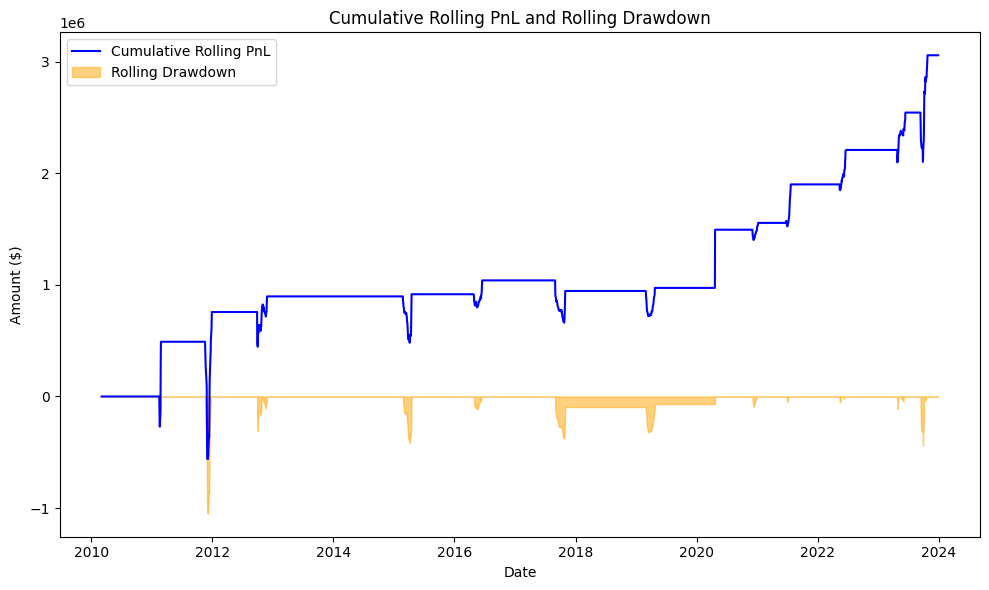

Testing beta_window=50, z_threshold=1.5
Engle-Granger p-value: 7.771103183304112e-06
Pair cointegrated. Proceeding with rolling beta.
Performance Metrics:
APL: 17457.6358
Sharpe Ratio: 0.0377
Max Drawdown: -2190843.7014
RoD: 0.0080


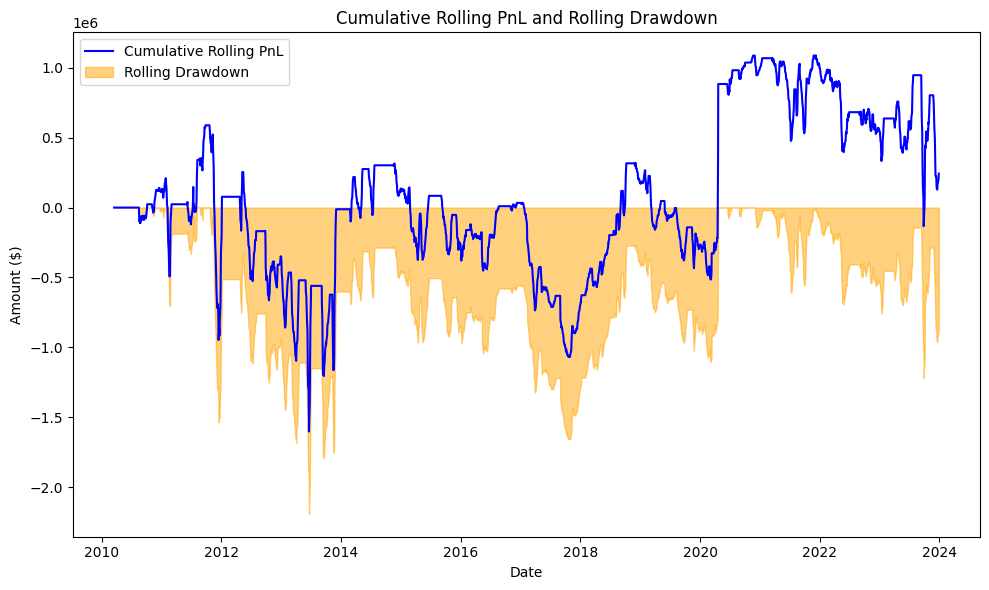

Testing beta_window=50, z_threshold=2.0
Engle-Granger p-value: 7.771103183304112e-06
Pair cointegrated. Proceeding with rolling beta.
Performance Metrics:
APL: 162789.4734
Sharpe Ratio: 0.4037
Max Drawdown: -1470298.3647
RoD: 0.1107


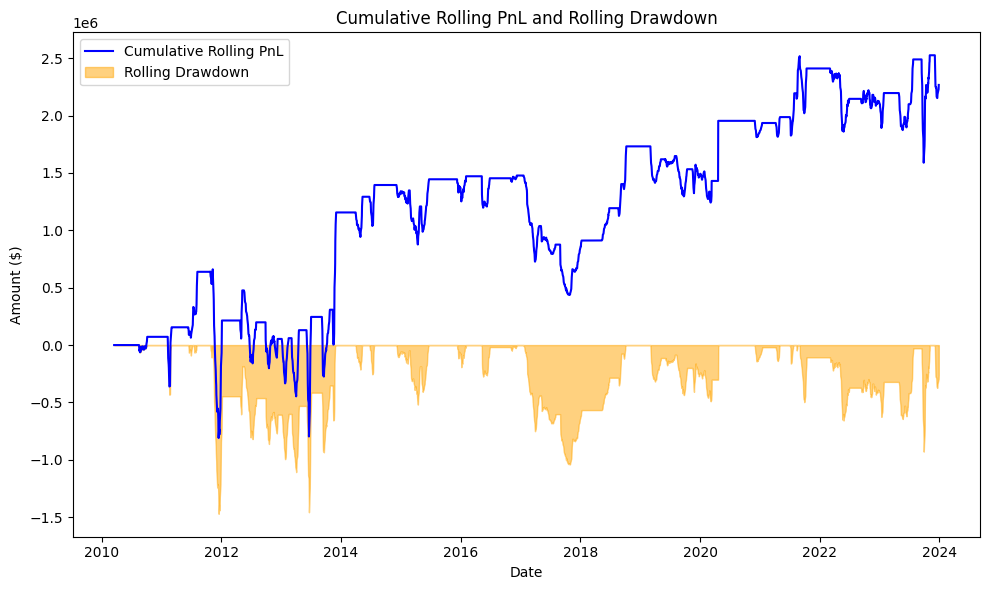

Testing beta_window=50, z_threshold=2.5
Engle-Granger p-value: 7.771103183304112e-06
Pair cointegrated. Proceeding with rolling beta.
Performance Metrics:
APL: 190410.6357
Sharpe Ratio: 0.5479
Max Drawdown: -1283093.3942
RoD: 0.1484


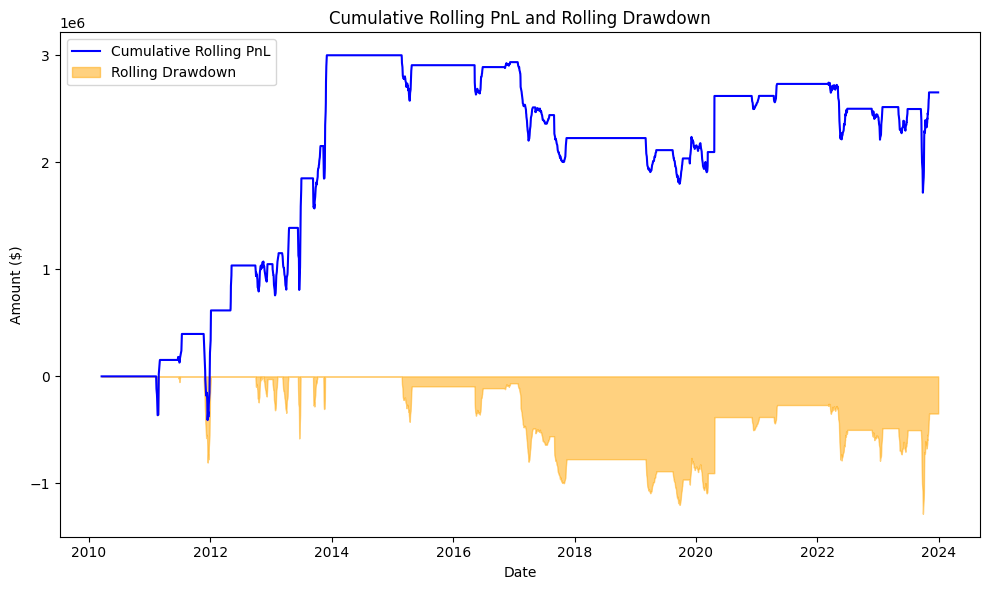

Testing beta_window=50, z_threshold=3.0
Engle-Granger p-value: 7.771103183304112e-06
Pair cointegrated. Proceeding with rolling beta.
Performance Metrics:
APL: 125412.6531
Sharpe Ratio: 0.5612
Max Drawdown: -688331.5337
RoD: 0.1822


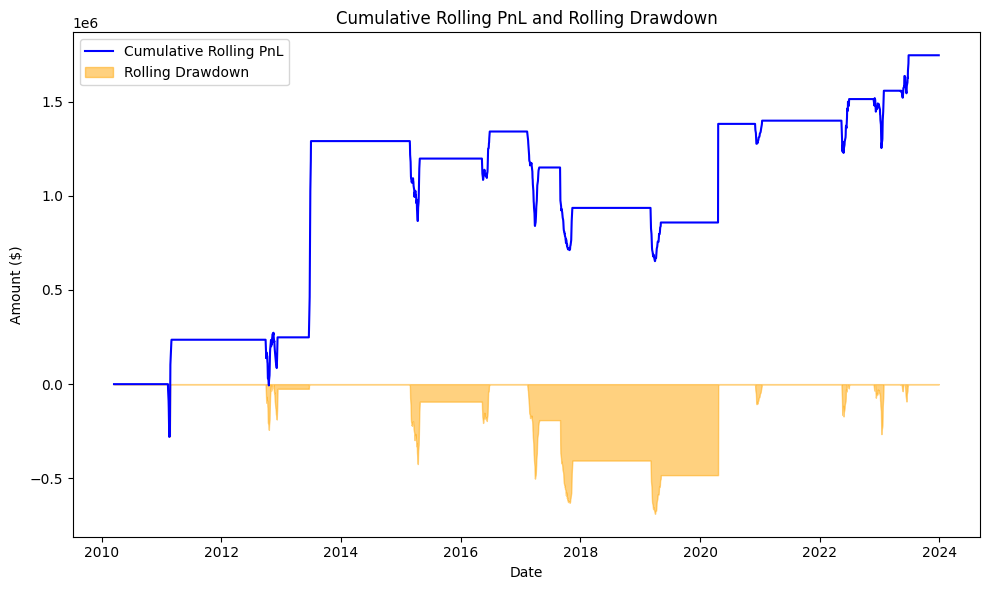

Best Parameters: (20, 1.5) Best Sharpe Ratio: 2.0636324396466215


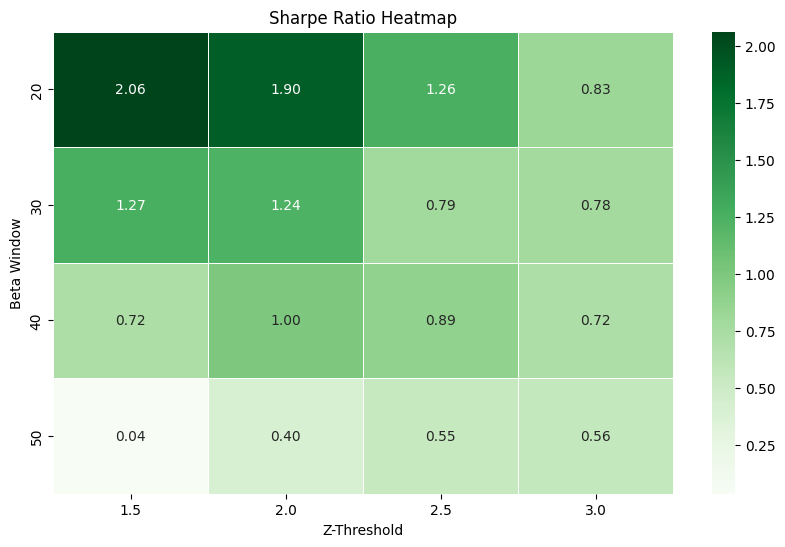

In [54]:
beta_values = [20, 30, 40, 50]
z_threshold_values = [1.5, 2.0, 2.5, 3.0]

results, best_params = optimize_sharpe_ratio(merged, "Crude", "RBOB", beta_values, z_threshold_values)


Engle-Granger p-value: 7.771103183304112e-06
Pair cointegrated. Proceeding with rolling beta.
Performance Metrics:
APL: 375817.0185
Sharpe Ratio: 0.7920
Max Drawdown: -1389355.2982
RoD: 0.2705


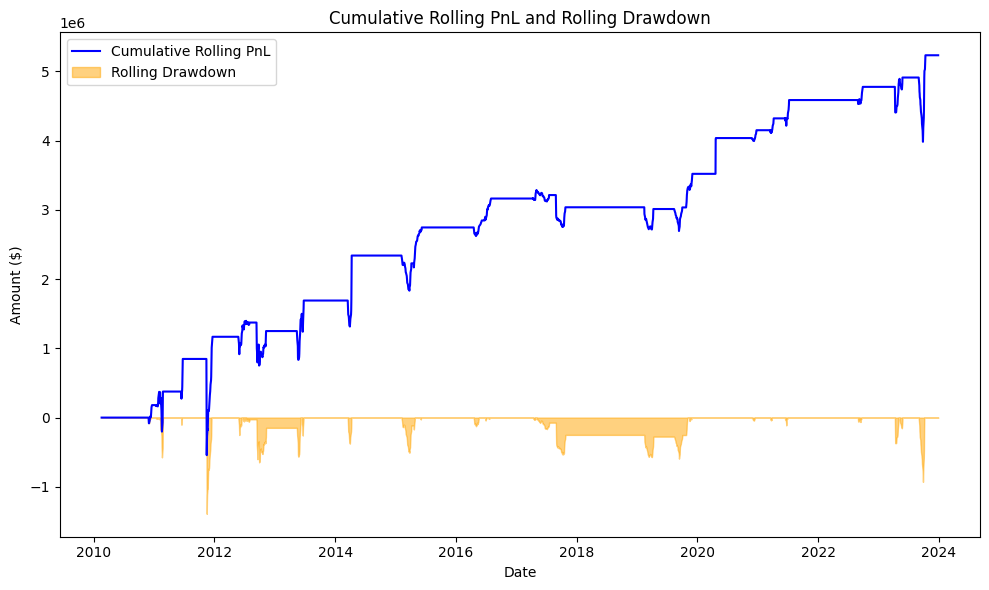

In [56]:
merged = run_pair_trading_strategy(merged, asset1='Crude', asset2='RBOB', beta_window=30, z_window=60, z_threshold=2.5)

# **Heatmap Crude-HO**

Testing beta_window=20, z_threshold=1.5
Engle-Granger p-value: 0.006916062625370155
Pair cointegrated. Proceeding with rolling beta.
Performance Metrics:
APL: 2028684.8341
Sharpe Ratio: 1.5912
Max Drawdown: -1545722.1596
RoD: 1.3125


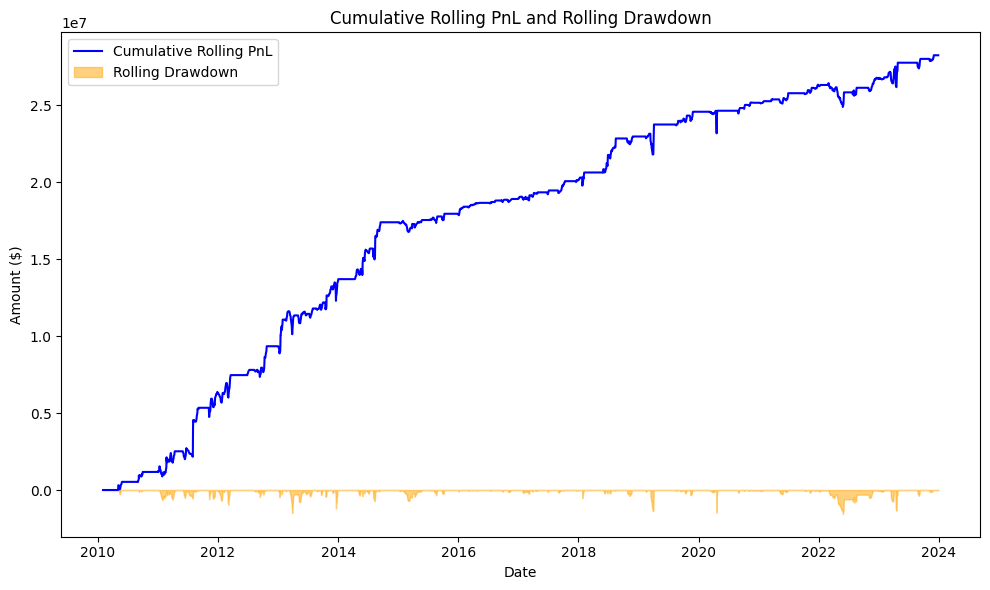

Testing beta_window=20, z_threshold=2.0
Engle-Granger p-value: 0.006916062625370155
Pair cointegrated. Proceeding with rolling beta.
Performance Metrics:
APL: 2053699.7565
Sharpe Ratio: 1.7211
Max Drawdown: -1464264.8813
RoD: 1.4025


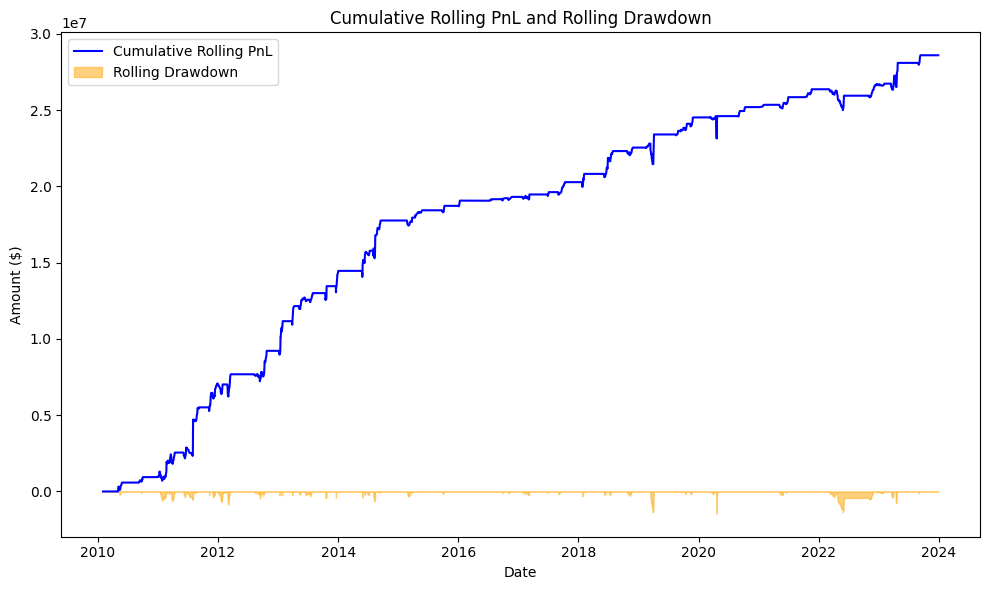

Testing beta_window=20, z_threshold=2.5
Engle-Granger p-value: 0.006916062625370155
Pair cointegrated. Proceeding with rolling beta.
Performance Metrics:
APL: 1729837.0912
Sharpe Ratio: 1.6628
Max Drawdown: -1352083.9204
RoD: 1.2794


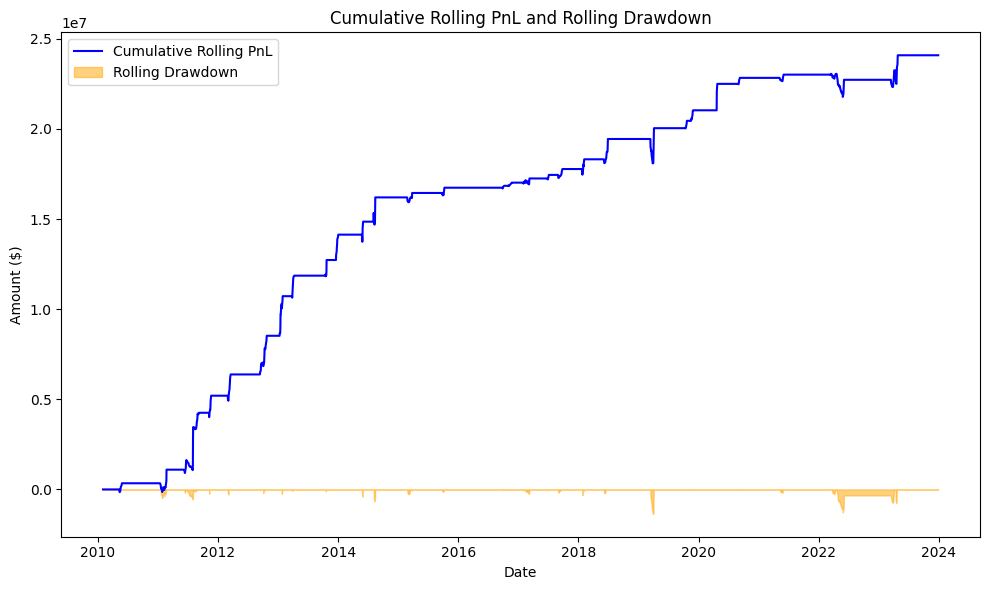

Testing beta_window=20, z_threshold=3.0
Engle-Granger p-value: 0.006916062625370155
Pair cointegrated. Proceeding with rolling beta.
Performance Metrics:
APL: 976844.1138
Sharpe Ratio: 1.4585
Max Drawdown: -905623.3087
RoD: 1.0786


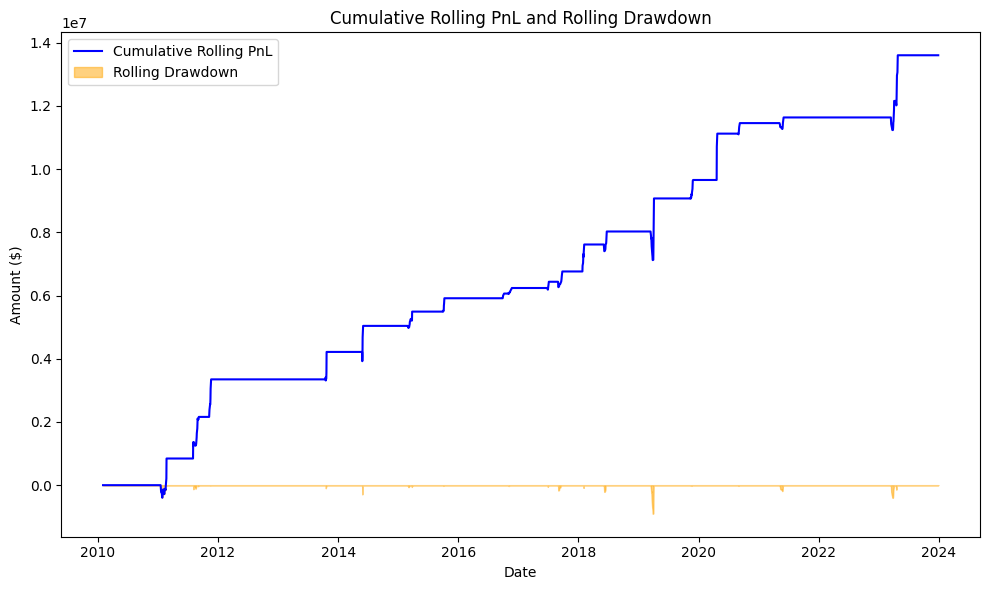

Testing beta_window=30, z_threshold=1.5
Engle-Granger p-value: 0.006916062625370155
Pair cointegrated. Proceeding with rolling beta.
Performance Metrics:
APL: 812052.4846
Sharpe Ratio: 1.1007
Max Drawdown: -1544173.2500
RoD: 0.5259


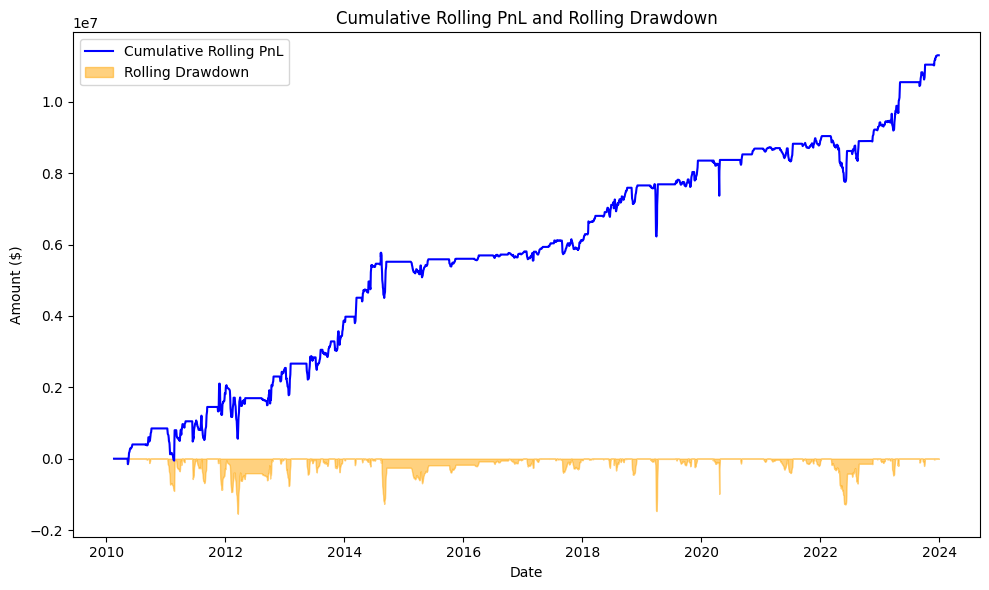

Testing beta_window=30, z_threshold=2.0
Engle-Granger p-value: 0.006916062625370155
Pair cointegrated. Proceeding with rolling beta.
Performance Metrics:
APL: 767172.4395
Sharpe Ratio: 1.1237
Max Drawdown: -1468199.3447
RoD: 0.5225


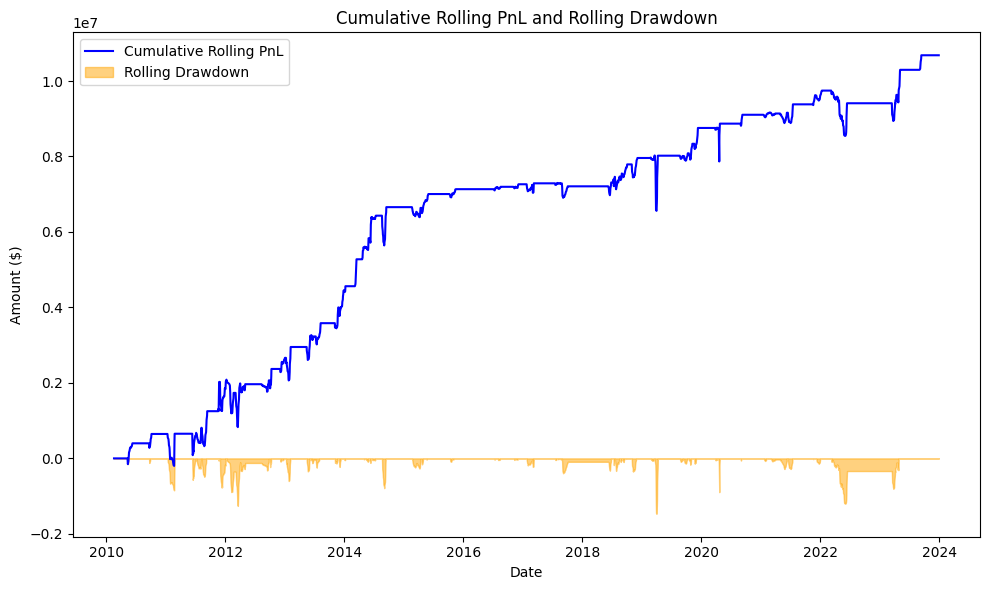

Testing beta_window=30, z_threshold=2.5
Engle-Granger p-value: 0.006916062625370155
Pair cointegrated. Proceeding with rolling beta.
Performance Metrics:
APL: 909854.3659
Sharpe Ratio: 1.6113
Max Drawdown: -1159345.4408
RoD: 0.7848


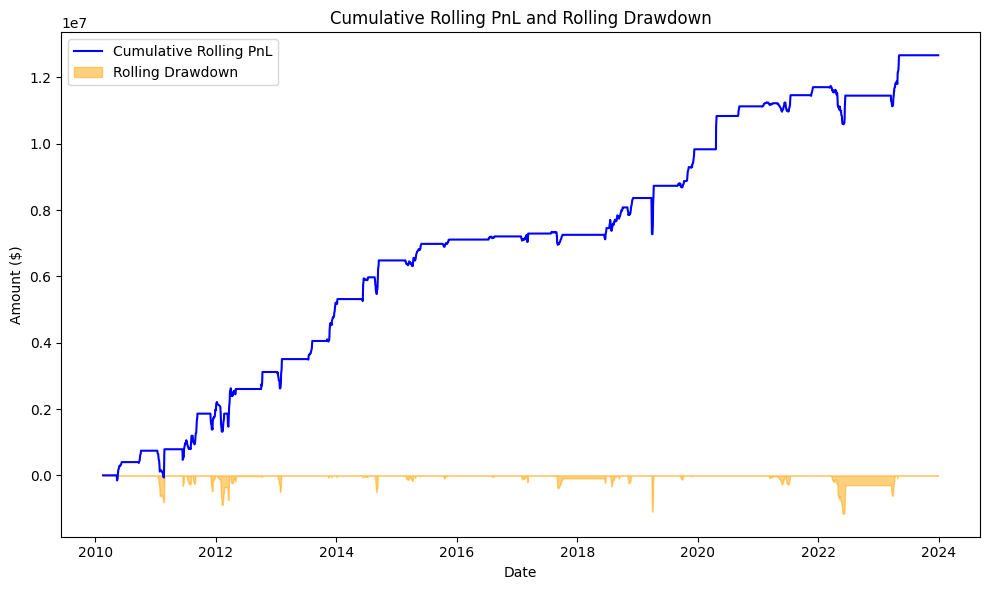

Testing beta_window=30, z_threshold=3.0
Engle-Granger p-value: 0.006916062625370155
Pair cointegrated. Proceeding with rolling beta.
Performance Metrics:
APL: 314240.4172
Sharpe Ratio: 0.7382
Max Drawdown: -1093667.1861
RoD: 0.2873


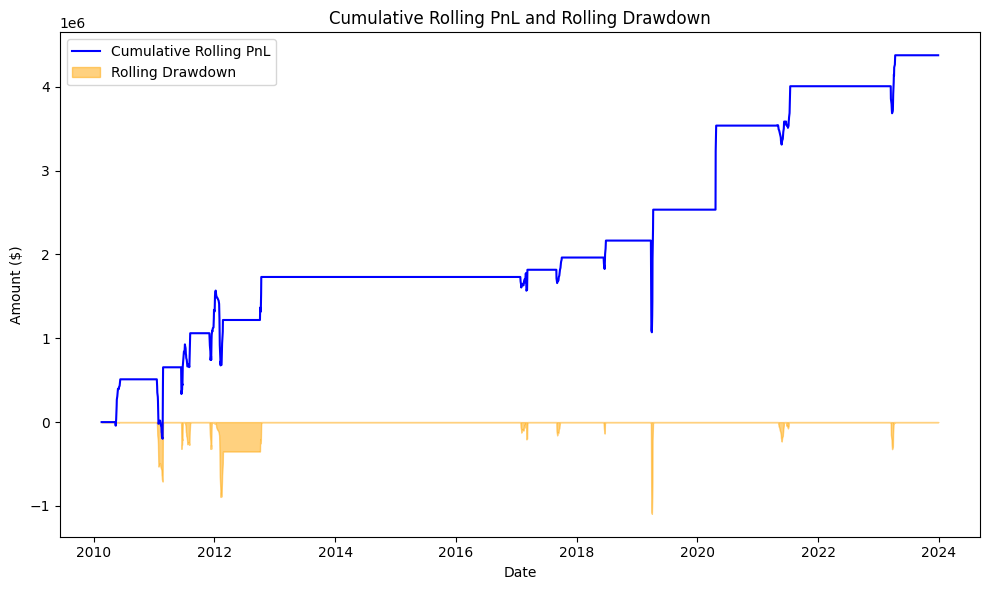

Testing beta_window=40, z_threshold=1.5
Engle-Granger p-value: 0.006916062625370155
Pair cointegrated. Proceeding with rolling beta.
Performance Metrics:
APL: 479208.6221
Sharpe Ratio: 0.8883
Max Drawdown: -1475586.9036
RoD: 0.3248


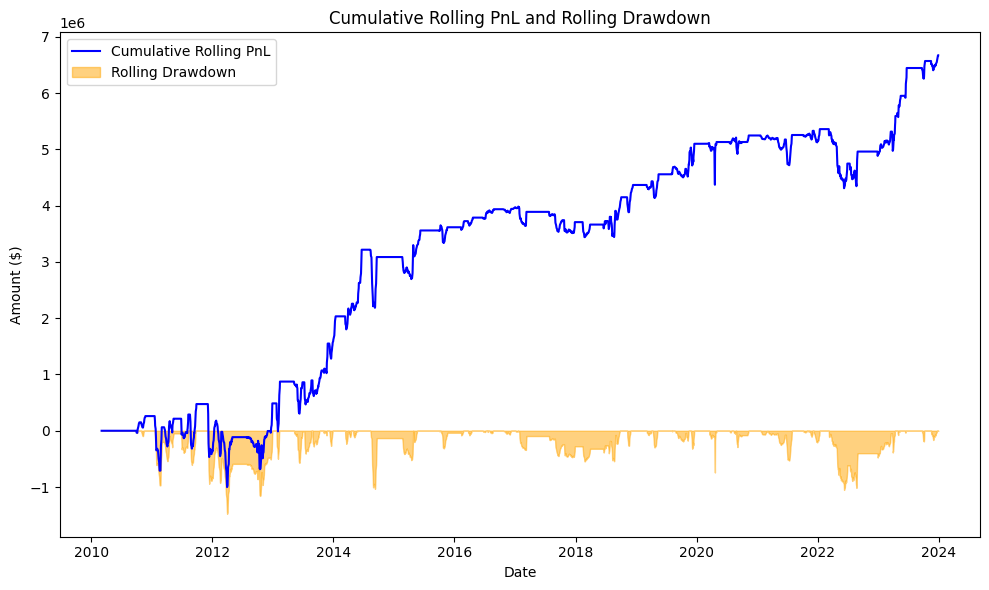

Testing beta_window=40, z_threshold=2.0
Engle-Granger p-value: 0.006916062625370155
Pair cointegrated. Proceeding with rolling beta.
Performance Metrics:
APL: 428581.5991
Sharpe Ratio: 0.8926
Max Drawdown: -1219063.5874
RoD: 0.3516


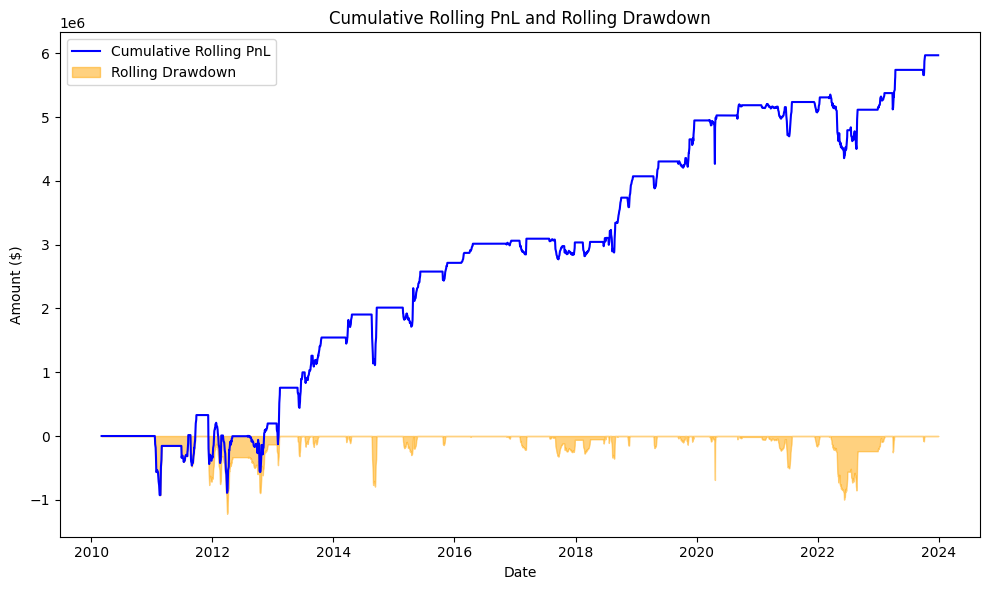

Testing beta_window=40, z_threshold=2.5
Engle-Granger p-value: 0.006916062625370155
Pair cointegrated. Proceeding with rolling beta.
Performance Metrics:
APL: 529514.1066
Sharpe Ratio: 1.3527
Max Drawdown: -800405.6752
RoD: 0.6616


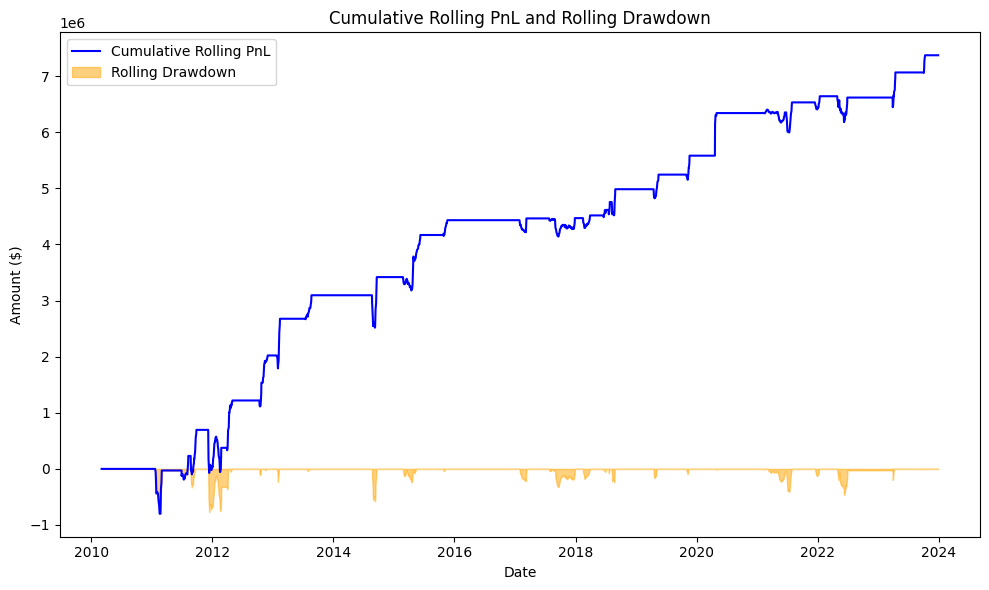

Testing beta_window=40, z_threshold=3.0
Engle-Granger p-value: 0.006916062625370155
Pair cointegrated. Proceeding with rolling beta.
Performance Metrics:
APL: 285545.5989
Sharpe Ratio: 0.9588
Max Drawdown: -743005.9373
RoD: 0.3843


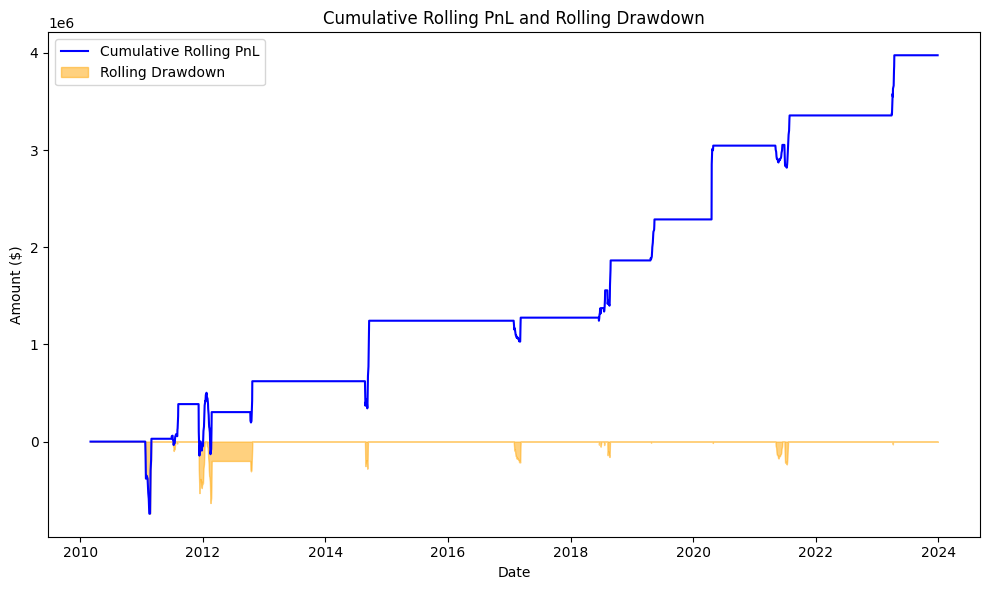

Testing beta_window=50, z_threshold=1.5
Engle-Granger p-value: 0.006916062625370155
Pair cointegrated. Proceeding with rolling beta.
Performance Metrics:
APL: 26841.7710
Sharpe Ratio: 0.0587
Max Drawdown: -1655041.3074
RoD: 0.0162


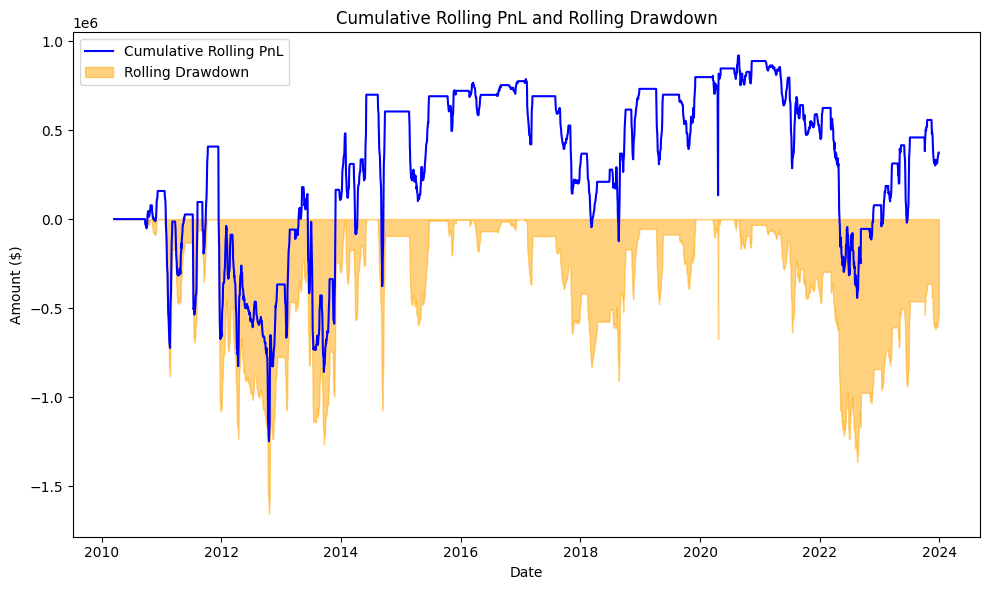

Testing beta_window=50, z_threshold=2.0
Engle-Granger p-value: 0.006916062625370155
Pair cointegrated. Proceeding with rolling beta.
Performance Metrics:
APL: 159804.6972
Sharpe Ratio: 0.3766
Max Drawdown: -1250230.4184
RoD: 0.1278


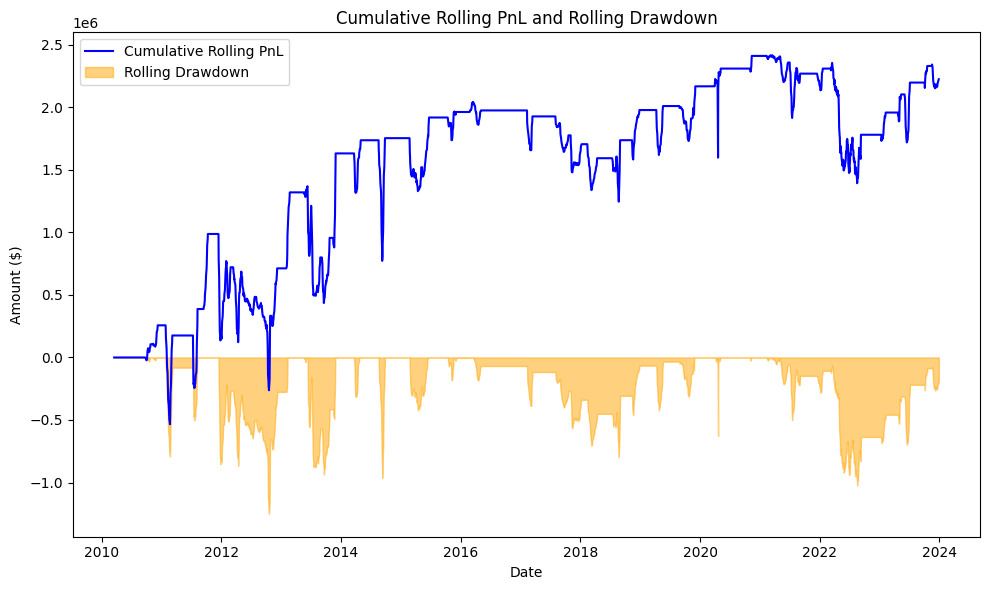

Testing beta_window=50, z_threshold=2.5
Engle-Granger p-value: 0.006916062625370155
Pair cointegrated. Proceeding with rolling beta.
Performance Metrics:
APL: 115675.7616
Sharpe Ratio: 0.3460
Max Drawdown: -977810.7272
RoD: 0.1183


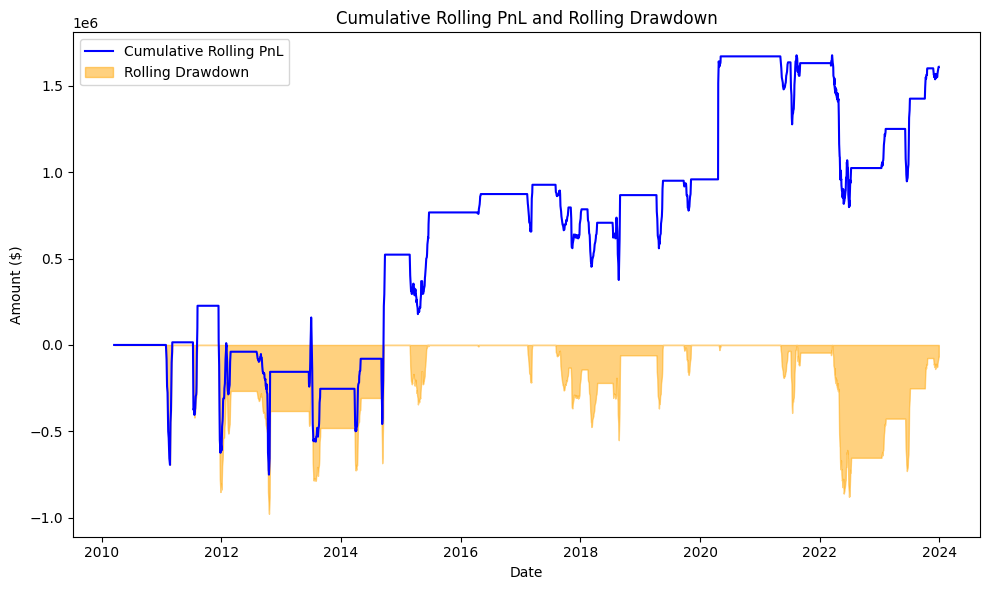

Testing beta_window=50, z_threshold=3.0
Engle-Granger p-value: 0.006916062625370155
Pair cointegrated. Proceeding with rolling beta.
Performance Metrics:
APL: 225432.7856
Sharpe Ratio: 0.8437
Max Drawdown: -649701.2818
RoD: 0.3470


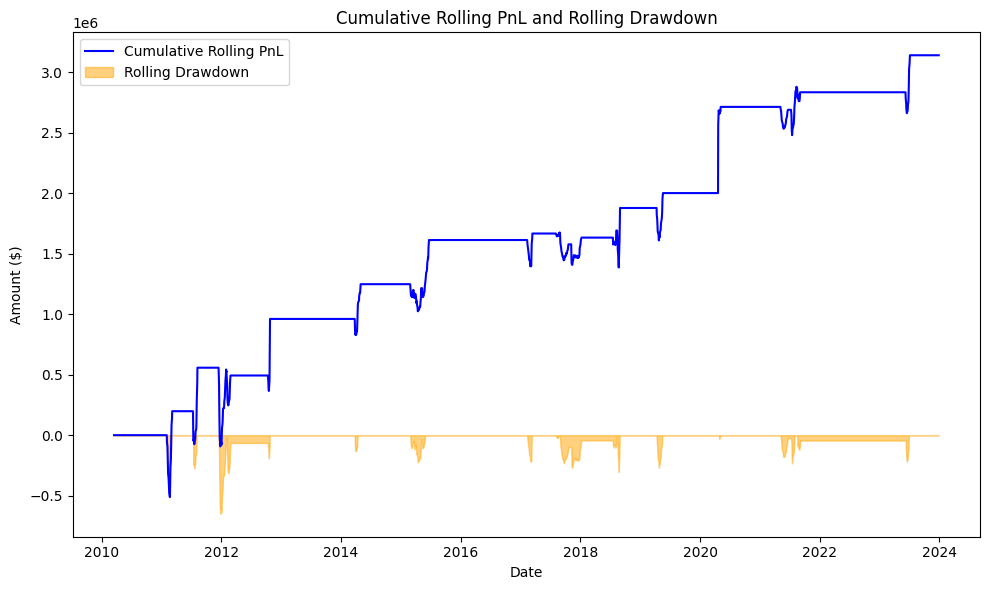

Best Parameters: (20, 2.0) Best Sharpe Ratio: 1.721102387863985


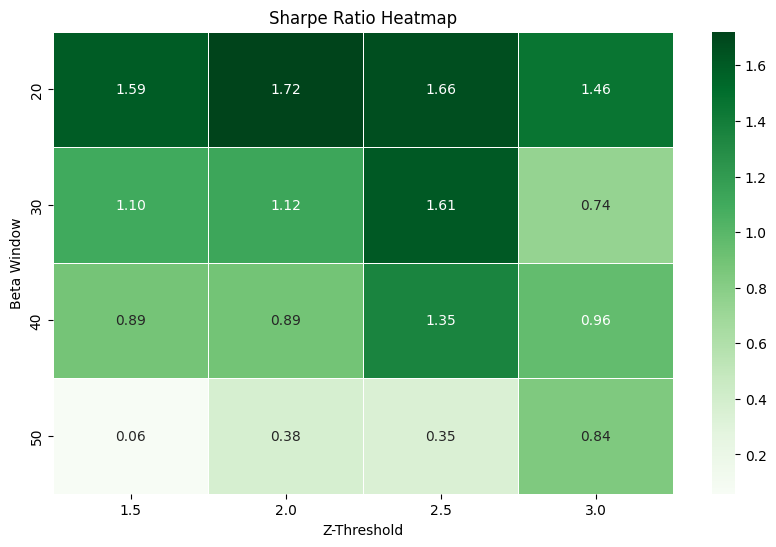

In [57]:
beta_values = [20, 30, 40, 50]
z_threshold_values = [1.5, 2.0, 2.5, 3.0]

results, best_params = optimize_sharpe_ratio(merged, "Crude", "HO", beta_values, z_threshold_values)


Engle-Granger p-value: 0.006916062625370155
Pair cointegrated. Proceeding with rolling beta.
Performance Metrics:
APL: 479208.6221
Sharpe Ratio: 0.8883
Max Drawdown: -1475586.9036
RoD: 0.3248


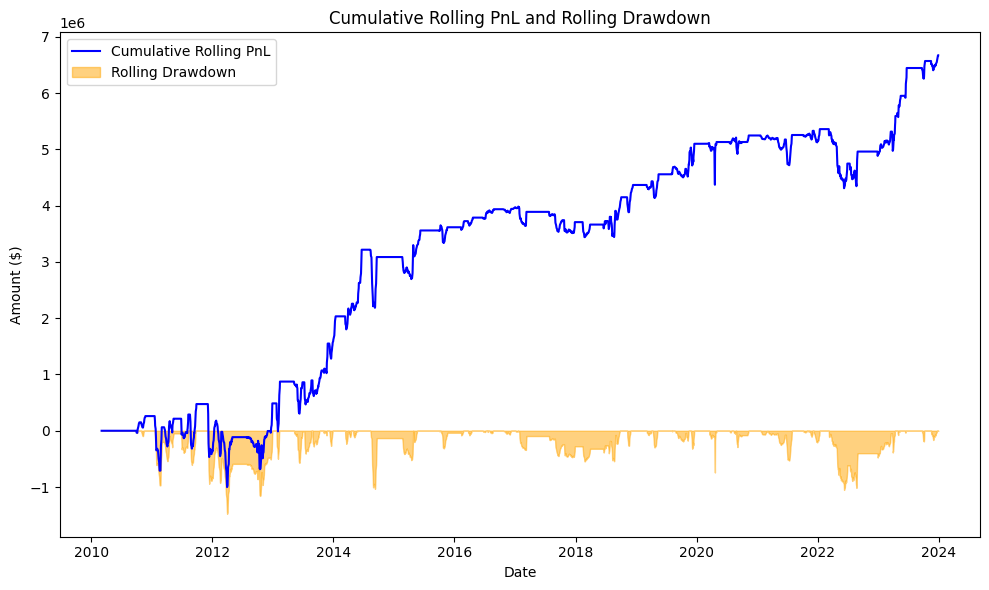

In [59]:
merged = run_pair_trading_strategy(merged, asset1='Crude', asset2='HO', beta_window=40, z_window=60, z_threshold=1.5)


# **Heatmap HO-RBOB**

Testing beta_window=20, z_threshold=1.5
Engle-Granger p-value: 0.0002592163300959771
Pair cointegrated. Proceeding with rolling beta.
Performance Metrics:
APL: 2214195.8594
Sharpe Ratio: 1.7150
Max Drawdown: -3342422.4523
RoD: 0.6625


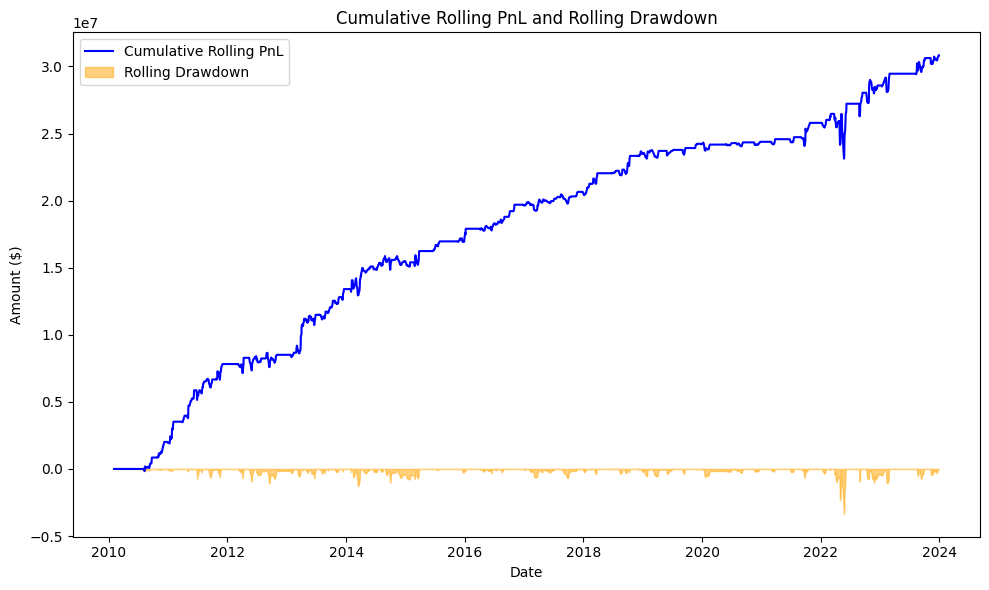

Testing beta_window=20, z_threshold=2.0
Engle-Granger p-value: 0.0002592163300959771
Pair cointegrated. Proceeding with rolling beta.
Performance Metrics:
APL: 1692841.2086
Sharpe Ratio: 1.4788
Max Drawdown: -2679546.9751
RoD: 0.6318


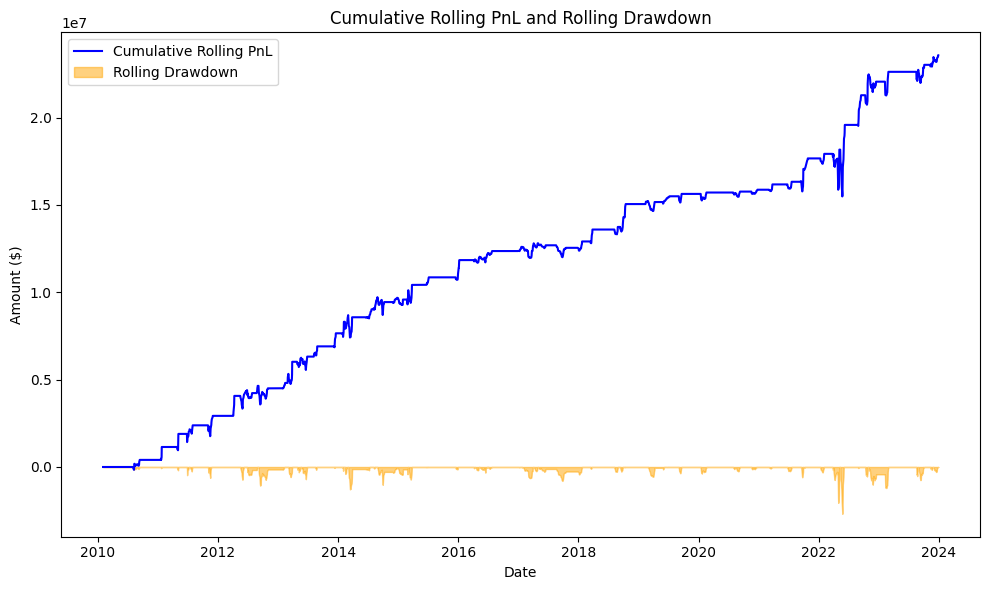

Testing beta_window=20, z_threshold=2.5
Engle-Granger p-value: 0.0002592163300959771
Pair cointegrated. Proceeding with rolling beta.
Performance Metrics:
APL: 1281150.4163
Sharpe Ratio: 1.3661
Max Drawdown: -2248990.6943
RoD: 0.5697


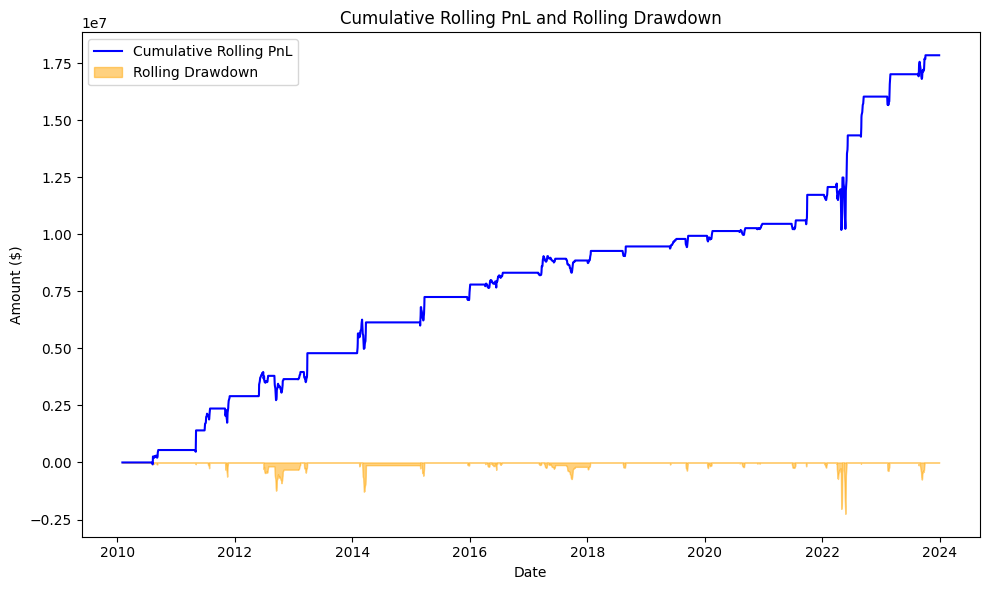

Testing beta_window=20, z_threshold=3.0
Engle-Granger p-value: 0.0002592163300959771
Pair cointegrated. Proceeding with rolling beta.
Performance Metrics:
APL: 879809.1235
Sharpe Ratio: 1.4017
Max Drawdown: -1066399.4752
RoD: 0.8250


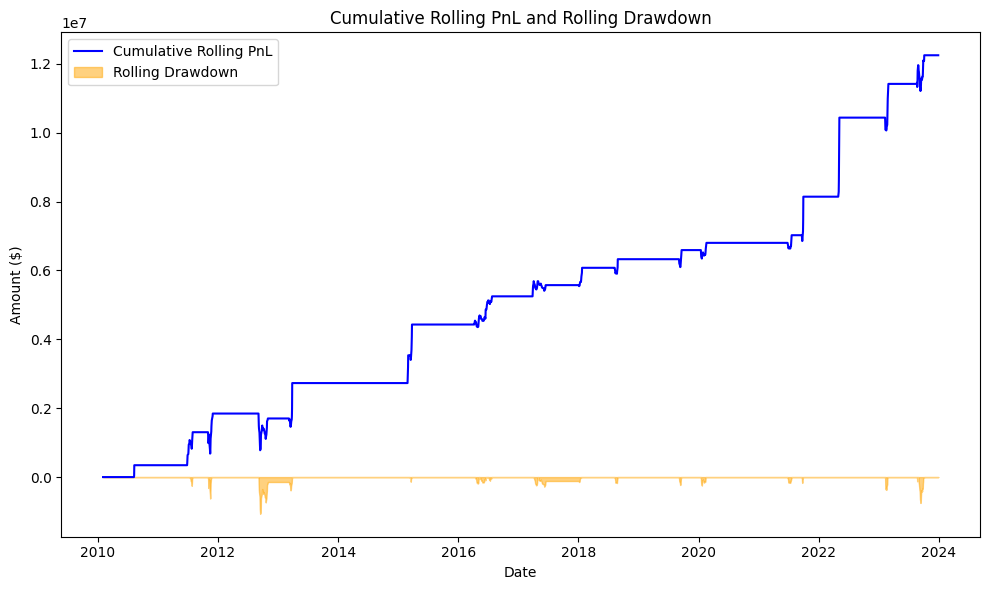

Testing beta_window=30, z_threshold=1.5
Engle-Granger p-value: 0.0002592163300959771
Pair cointegrated. Proceeding with rolling beta.
Performance Metrics:
APL: 628508.8823
Sharpe Ratio: 0.7334
Max Drawdown: -2027922.2455
RoD: 0.3099


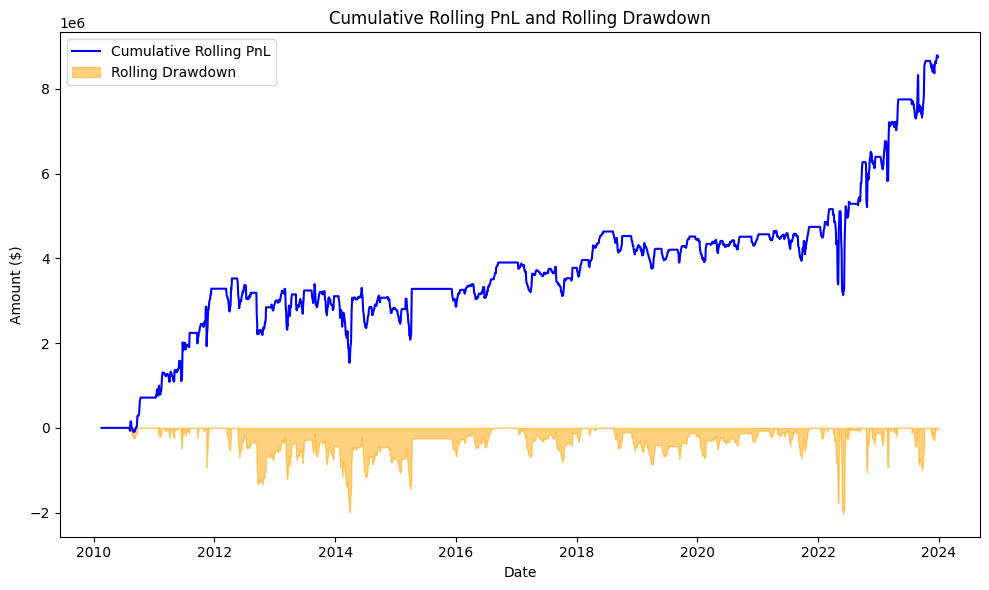

Testing beta_window=30, z_threshold=2.0
Engle-Granger p-value: 0.0002592163300959771
Pair cointegrated. Proceeding with rolling beta.
Performance Metrics:
APL: 684080.0495
Sharpe Ratio: 0.8925
Max Drawdown: -1665465.7452
RoD: 0.4107


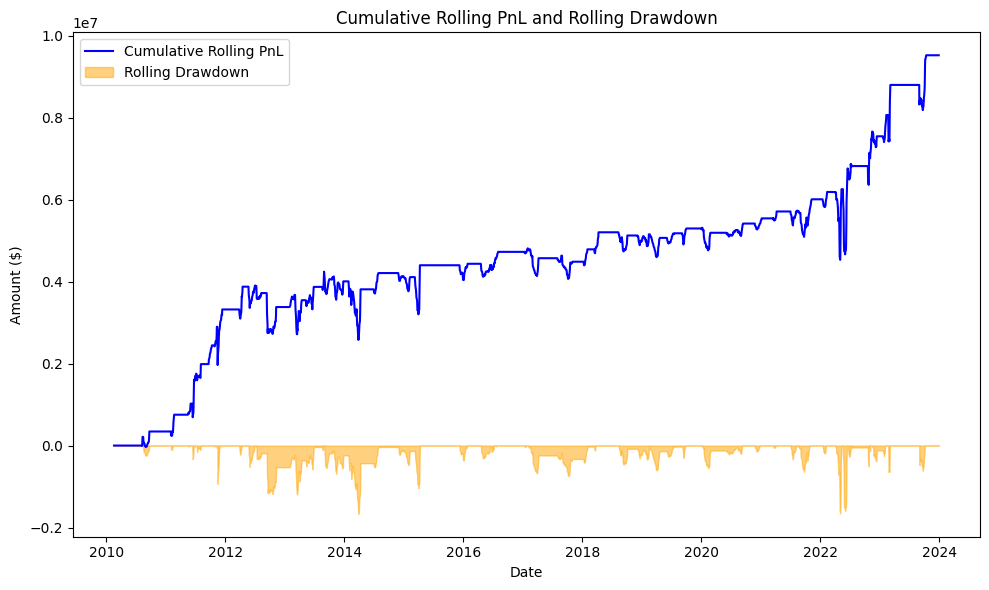

Testing beta_window=30, z_threshold=2.5
Engle-Granger p-value: 0.0002592163300959771
Pair cointegrated. Proceeding with rolling beta.
Performance Metrics:
APL: 671562.3285
Sharpe Ratio: 0.9808
Max Drawdown: -1620399.4198
RoD: 0.4144


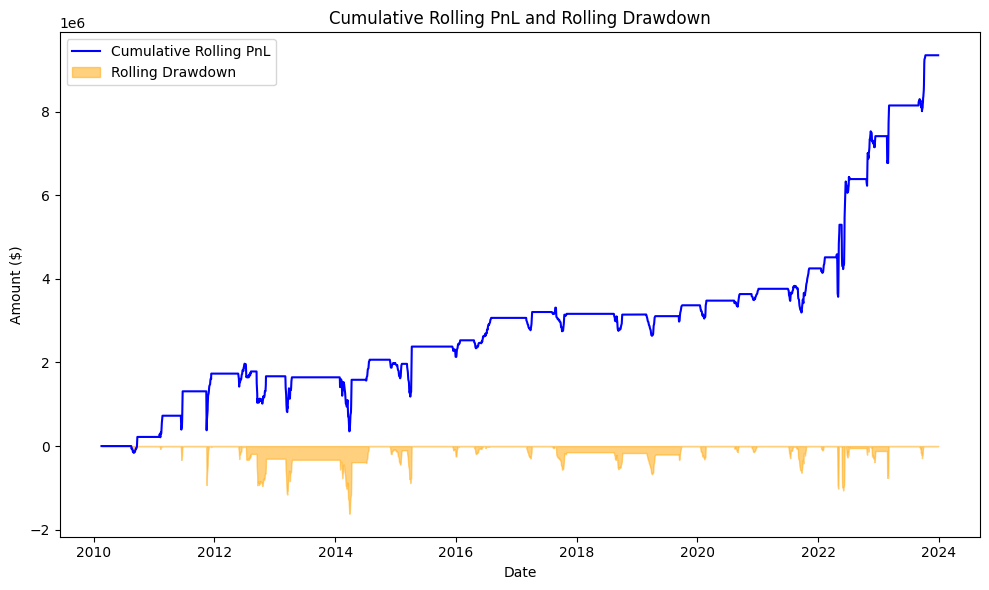

Testing beta_window=30, z_threshold=3.0
Engle-Granger p-value: 0.0002592163300959771
Pair cointegrated. Proceeding with rolling beta.
Performance Metrics:
APL: 481548.6144
Sharpe Ratio: 0.8763
Max Drawdown: -1247719.2568
RoD: 0.3859


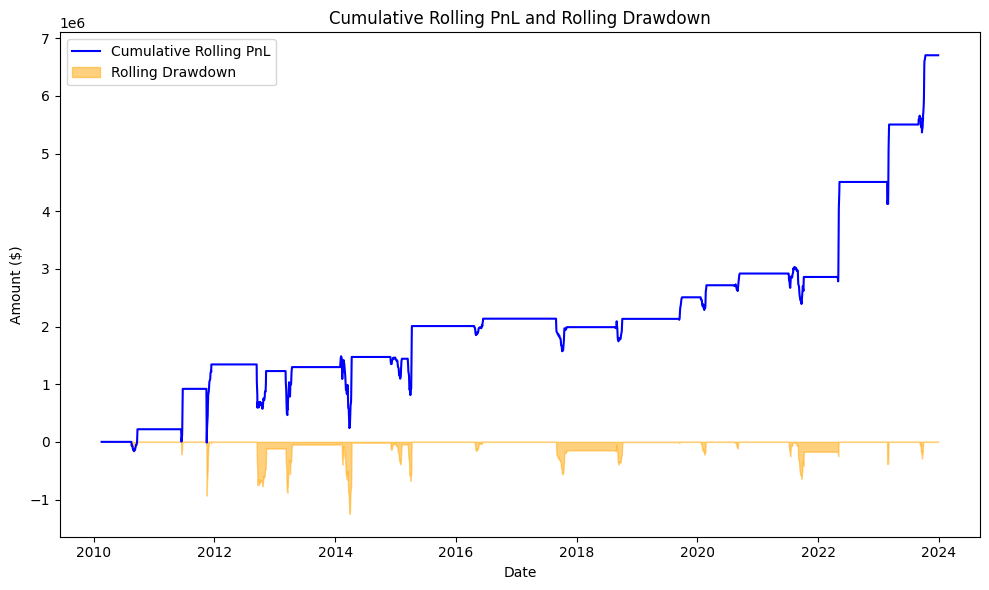

Testing beta_window=40, z_threshold=1.5
Engle-Granger p-value: 0.0002592163300959771
Pair cointegrated. Proceeding with rolling beta.
Performance Metrics:
APL: 61650.3171
Sharpe Ratio: 0.0932
Max Drawdown: -3411903.9529
RoD: 0.0181


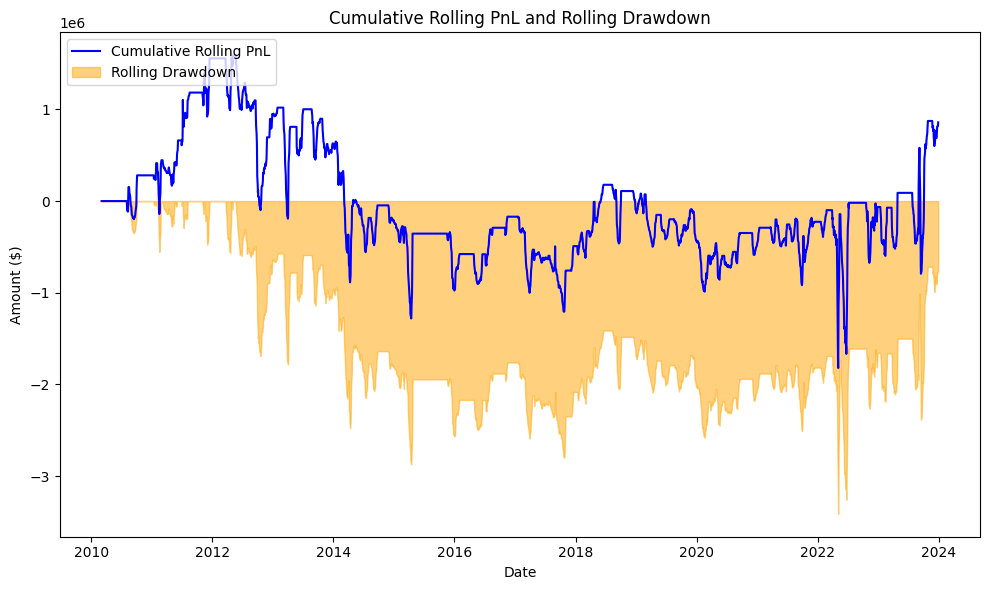

Testing beta_window=40, z_threshold=2.0
Engle-Granger p-value: 0.0002592163300959771
Pair cointegrated. Proceeding with rolling beta.
Performance Metrics:
APL: 468123.0121
Sharpe Ratio: 0.7609
Max Drawdown: -2017436.2641
RoD: 0.2320


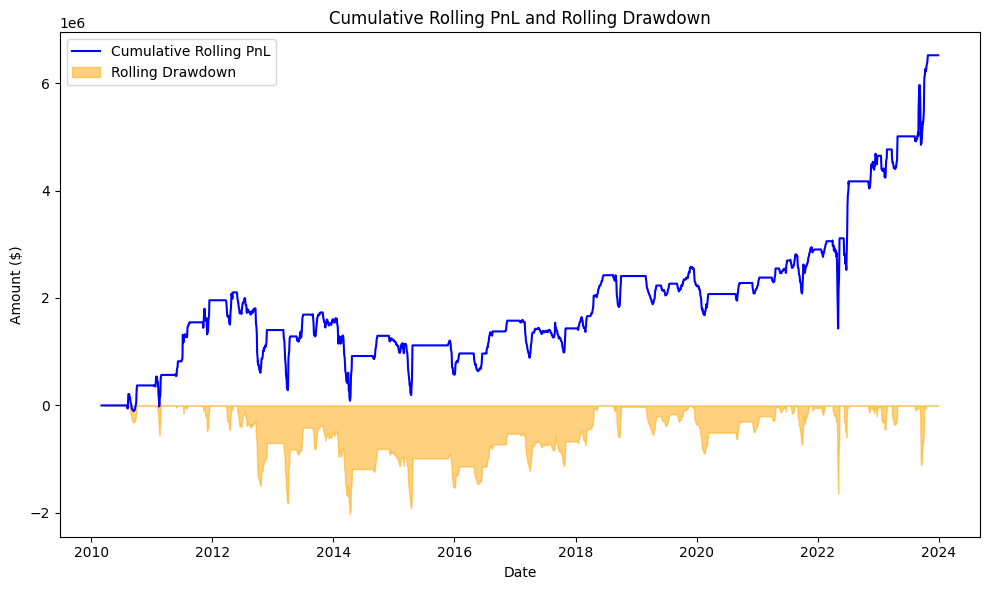

Testing beta_window=40, z_threshold=2.5
Engle-Granger p-value: 0.0002592163300959771
Pair cointegrated. Proceeding with rolling beta.
Performance Metrics:
APL: 366106.3616
Sharpe Ratio: 0.7529
Max Drawdown: -1691605.3694
RoD: 0.2164


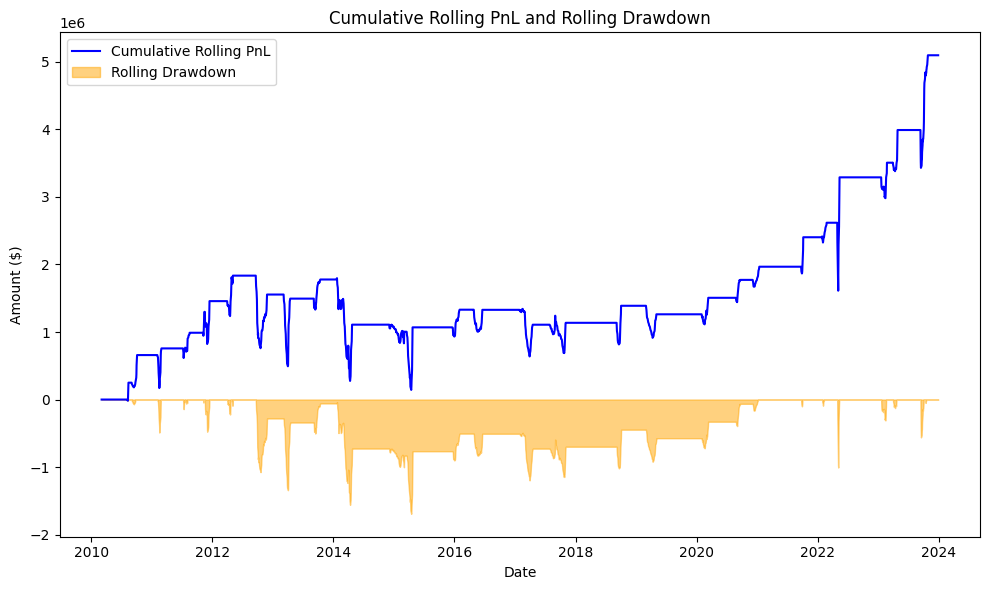

Testing beta_window=40, z_threshold=3.0
Engle-Granger p-value: 0.0002592163300959771
Pair cointegrated. Proceeding with rolling beta.
Performance Metrics:
APL: 62929.3540
Sharpe Ratio: 0.1616
Max Drawdown: -1727029.4251
RoD: 0.0364


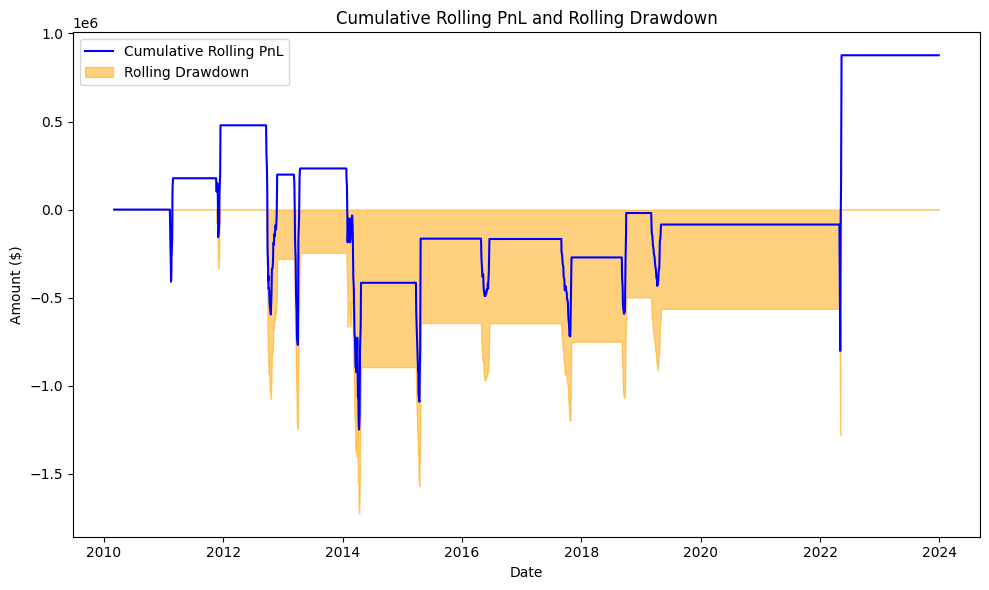

Testing beta_window=50, z_threshold=1.5
Engle-Granger p-value: 0.0002592163300959771
Pair cointegrated. Proceeding with rolling beta.
Performance Metrics:
APL: -268682.3550
Sharpe Ratio: -0.4873
Max Drawdown: -5470198.0747
RoD: -0.0491


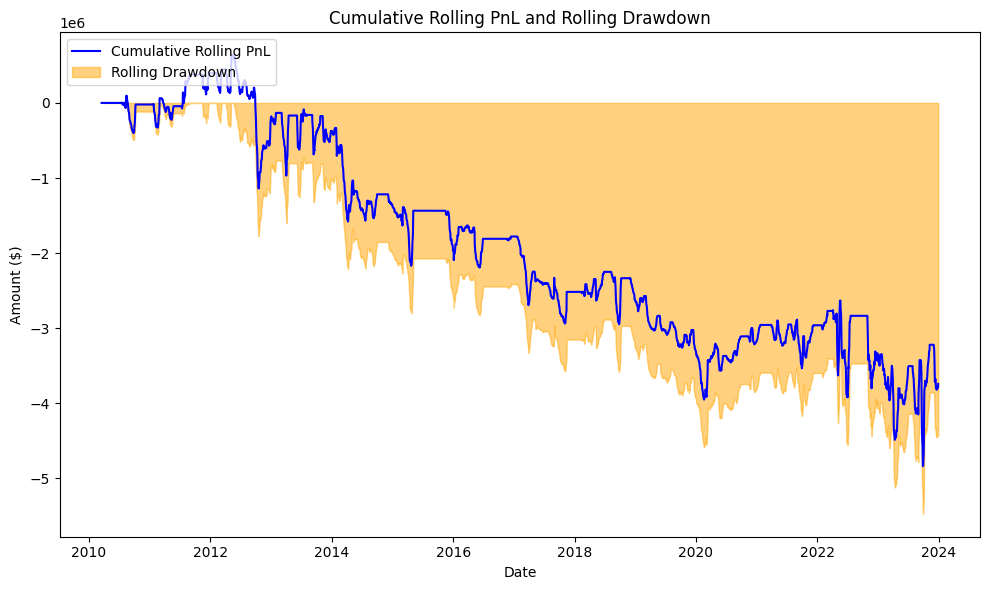

Testing beta_window=50, z_threshold=2.0
Engle-Granger p-value: 0.0002592163300959771
Pair cointegrated. Proceeding with rolling beta.
Performance Metrics:
APL: 55751.0960
Sharpe Ratio: 0.1105
Max Drawdown: -2564090.9870
RoD: 0.0217


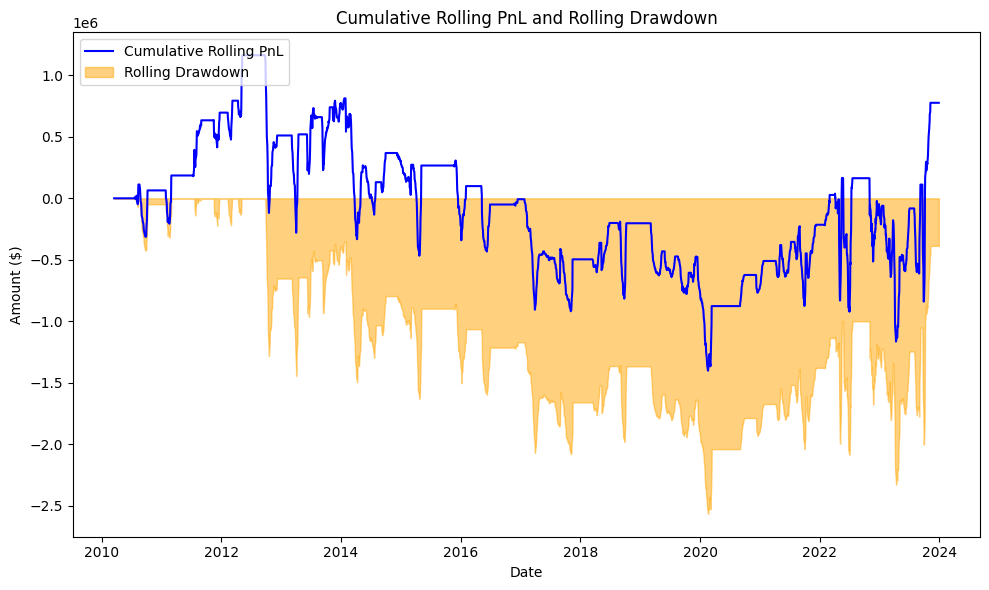

Testing beta_window=50, z_threshold=2.5
Engle-Granger p-value: 0.0002592163300959771
Pair cointegrated. Proceeding with rolling beta.
Performance Metrics:
APL: 221876.9941
Sharpe Ratio: 0.4938
Max Drawdown: -1273325.6142
RoD: 0.1743


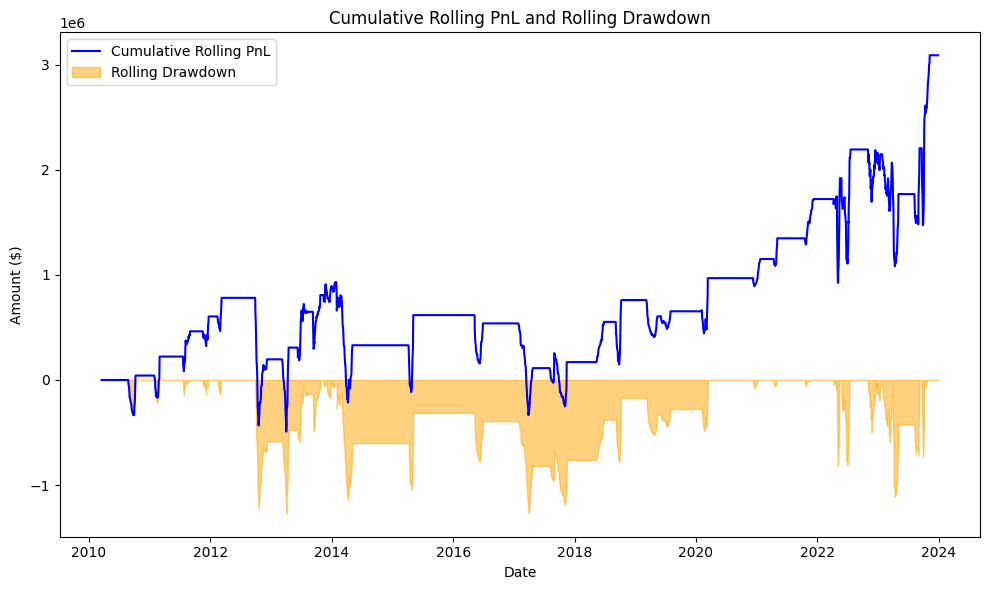

Testing beta_window=50, z_threshold=3.0
Engle-Granger p-value: 0.0002592163300959771
Pair cointegrated. Proceeding with rolling beta.
Performance Metrics:
APL: 52442.4987
Sharpe Ratio: 0.2103
Max Drawdown: -1499424.3143
RoD: 0.0350


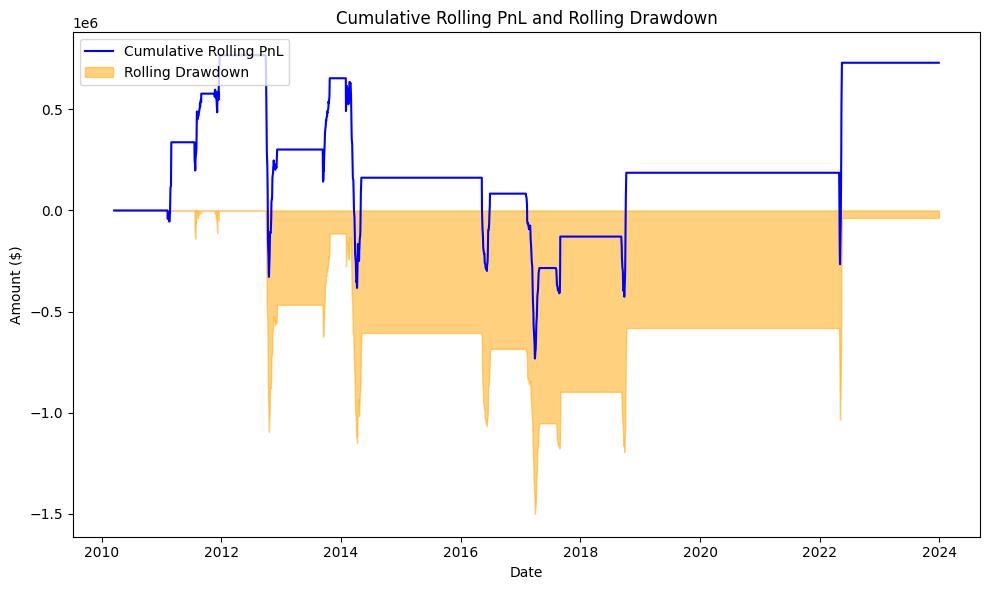

Best Parameters: (20, 1.5) Best Sharpe Ratio: 1.7149718739327438


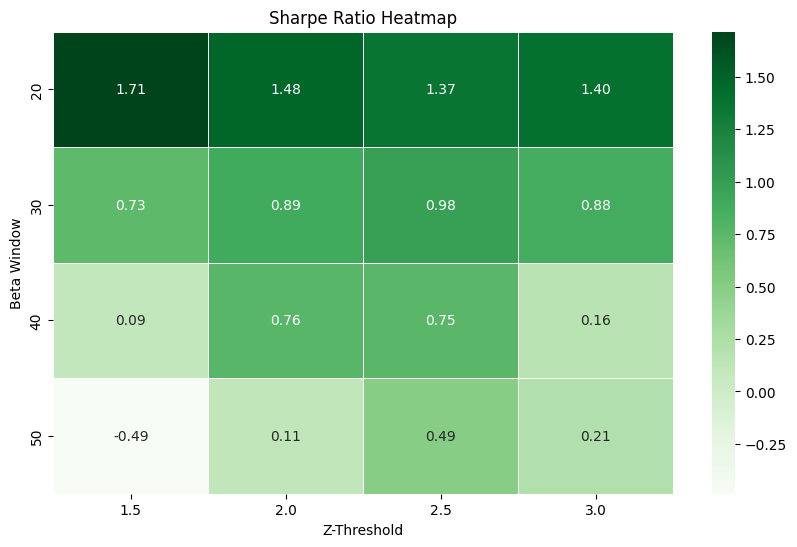

In [58]:
beta_values = [20, 30, 40, 50]
z_threshold_values = [1.5, 2.0, 2.5, 3.0]

results, best_params = optimize_sharpe_ratio(merged, "HO", "RBOB", beta_values, z_threshold_values)


Engle-Granger p-value: 0.0002592163300959771
Pair cointegrated. Proceeding with rolling beta.
Performance Metrics:
APL: 684080.0495
Sharpe Ratio: 0.8925
Max Drawdown: -1665465.7452
RoD: 0.4107


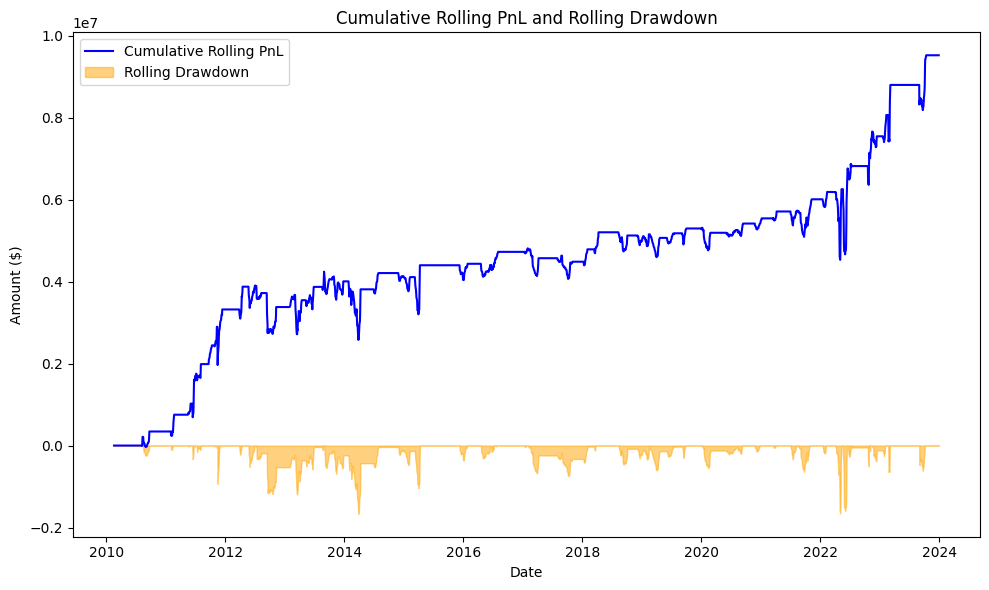

In [60]:
merged = run_pair_trading_strategy(merged, asset1='HO', asset2='RBOB', beta_window=30, z_window=60, z_threshold=2)


# **Adding signals from Fundamental Features**

# Using both US_Inventory_Change and Midwest_Inventory_Change

<ipython-input-62-c590ea9c88d8>:21: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  merged['US_Inventory_Change'] = merged['Weekly U.S. Ending Stocks excluding SPR of Crude Oil and Petroleum Products  (Thousand Barrels)'].pct_change()
<ipython-input-62-c590ea9c88d8>:22: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  merged['Midwest_Inventory_Change'] = merged['Weekly Midwest (PADD 2) Ending Stocks excluding SPR of Crude Oil  (Thousand Barrels)'].pct_change()


Engle-Granger p-value: 7.771103183303982e-06
Pair cointegrated. Proceeding with rolling beta.
Performance Metrics:
APL: 52342.7293
Sharpe Ratio: 0.2466
Max Drawdown: -630084.0687
RoD: 0.0831


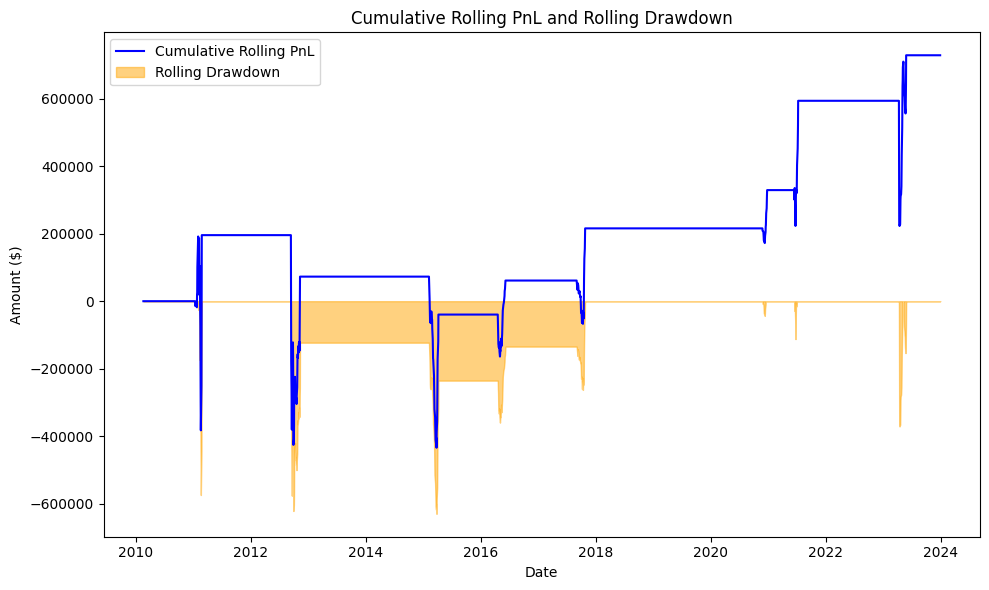

In [62]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import math

# Load fundamental data and the merged price data
fundamental_data = pd.read_csv('fundamental_data.csv')
merged = pd.read_csv('merged.csv', parse_dates=['Date'])

# Preprocess the fundamental data, converting 'Date' to datetime format
fundamental_data['Date'] = pd.to_datetime(fundamental_data['Date'], format='%b %d, %Y')


merged = pd.merge(merged, fundamental_data[['Date',
                                             'Weekly U.S. Ending Stocks excluding SPR of Crude Oil and Petroleum Products  (Thousand Barrels)',
                                             'Weekly Midwest (PADD 2) Ending Stocks excluding SPR of Crude Oil  (Thousand Barrels)']],
                  on='Date', how='left')

# Calculate the percentage change in the inventory columns
merged['US_Inventory_Change'] = merged['Weekly U.S. Ending Stocks excluding SPR of Crude Oil and Petroleum Products  (Thousand Barrels)'].pct_change()
merged['Midwest_Inventory_Change'] = merged['Weekly Midwest (PADD 2) Ending Stocks excluding SPR of Crude Oil  (Thousand Barrels)'].pct_change()

# Create signals based on quantiles for significant changes in inventory
merged['US_Inventory_Signal'] = 0  # Default value
merged['Midwest_Inventory_Signal'] = 0  # Default value

# Quantile-based signal generation: Long if inventory decreases significantly (lowest 20%), Short if inventory increases significantly (highest 20%)
merged.loc[merged['US_Inventory_Change'] < merged['US_Inventory_Change'].quantile(0.2), 'US_Inventory_Signal'] = 1  # Buy Signal
merged.loc[merged['US_Inventory_Change'] > merged['US_Inventory_Change'].quantile(0.8), 'US_Inventory_Signal'] = -1  # Sell Signal

merged.loc[merged['Midwest_Inventory_Change'] < merged['Midwest_Inventory_Change'].quantile(0.2), 'Midwest_Inventory_Signal'] = 1  # Buy Signal
merged.loc[merged['Midwest_Inventory_Change'] > merged['Midwest_Inventory_Change'].quantile(0.8), 'Midwest_Inventory_Signal'] = -1  # Sell Signal

# Forward fill the inventory signals to propagate them throughout the week (and keep the previous value until new value)
merged['US_Inventory_Signal'] = merged['US_Inventory_Signal'].replace(0, np.nan).ffill()  # Replace 0 with NaN and forward fill
merged['Midwest_Inventory_Signal'] = merged['Midwest_Inventory_Signal'].replace(0, np.nan).ffill()  # Replace 0 with NaN and forward fill

# Modify the trading strategy to filter entries based on the new signal
def run_pair_trading_with_inventory_signal(merged, asset1, asset2, beta_window=30, z_window=60, z_threshold=1.5):
    # Dynamically select the columns for asset1 and asset2 (Crude, HO, or RBOB)
    asset1_f1 = f'{asset1}_F1'
    asset2_f1 = f'{asset2}_F1'

    # Engle-Granger Cointegration Test
    pvalue = engle_granger_test(merged[asset1_f1], merged[asset2_f1])
    print(f"Engle-Granger p-value: {pvalue}")

    if pvalue >= 0.05:
        print("Pair not cointegrated. Stop here or try another pair.")
        return
    else:
        print("Pair cointegrated. Proceeding with rolling beta.")

    # Rolling Beta
    merged['Rolling_Beta'] = (
        merged[asset1_f1].rolling(window=beta_window).cov(merged[asset2_f1])
        / merged[asset2_f1].rolling(window=beta_window).var()
    )

    # Compute Spread
    merged['Spread'] = merged[asset1_f1] - merged['Rolling_Beta'] * merged[asset2_f1]

    # Compute Rolling Mean, Std, and Z-score
    merged['Spread_Mean'] = merged['Spread'].rolling(window=z_window).mean()
    merged['Spread_Std'] = merged['Spread'].rolling(window=z_window).std()
    merged['Z_Score'] = (merged['Spread'] - merged['Spread_Mean']) / merged['Spread_Std']

    # Generate Trading Signals: Filter based on Inventory Signal
    merged['Position'] = 0  # Initialize position column

    for i in range(1, len(merged)):
        # Check if the fundamental signal aligns with the position
        if merged['Z_Score'].iloc[i] > z_threshold and merged['US_Inventory_Signal'].iloc[i] == -1 and merged['Midwest_Inventory_Signal'].iloc[i] == -1:
            merged.at[merged.index[i], 'Position'] = -1  # Short Spread
        elif merged['Z_Score'].iloc[i] < -z_threshold and merged['US_Inventory_Signal'].iloc[i] == 1 and merged['Midwest_Inventory_Signal'].iloc[i] == 1:
            merged.at[merged.index[i], 'Position'] = 1   # Long Spread
        elif merged['Position'].iloc[i-1] == 1 and merged['Z_Score'].iloc[i] >= 0:
            merged.at[merged.index[i], 'Position'] = 0   # Close Long
        elif merged['Position'].iloc[i-1] == -1 and merged['Z_Score'].iloc[i] <= 0:
            merged.at[merged.index[i], 'Position'] = 0   # Close Short
        else:
            merged.at[merged.index[i], 'Position'] = merged['Position'].iloc[i-1]  # Hold previous position

    scaling_factor = 10 * 1000

    # 8. Calculate PnL (Using Previous Signal to Avoid Bias)
    merged['Spread_Return'] = merged['Spread'].diff()  # Daily change in spread
    merged['Strategy_Return'] = merged['Position'].shift(1) * merged['Spread_Return']  # Previous day's position * today's return

    # Scale the strategy return
    merged['Scaled_Strategy_Return'] = merged['Strategy_Return'] * scaling_factor

    # 9. Compute Cumulative PnL (Using the Scaled Strategy Return)
    merged['Cumulative_PnL'] = merged['Scaled_Strategy_Return'].cumsum()

    # 10. Calculate APL (Annualized PnL)
    total_pnl = merged['Scaled_Strategy_Return'].sum()  # Sum of strategy returns using the scaled return
    days_in_dataset = len(merged)
    APL = total_pnl / (days_in_dataset / 252)  # Annualized PnL

    # 11. Calculate Sharpe Ratio
    daily_std = merged['Strategy_Return'].std()
    global_sharpe_ratio = APL / (daily_std * math.sqrt(250) * scaling_factor)  # Assume 250 trading days in a year

    # Compute Cumulative Rolling PnL using the scaled return
    merged['Rolling_Cumulative_PnL'] = merged['Scaled_Strategy_Return'].cumsum()

    # 12. Calculate Highest Maximum Value of Cumulative PnL (HMW)
    merged['Rolling_HMW'] = merged['Rolling_Cumulative_PnL'].cummax()  # Highest Maximum Value (Cumulative PnL)

    # 13. Calculate Drawdown (DD)
    merged['Rolling_Drawdown'] = merged['Rolling_Cumulative_PnL'] - merged['Rolling_HMW']  # Negative drawdown

    # 14. Calculate Maximum Drawdown (Max DD)
    max_dd = merged['Rolling_Drawdown'].min()  # Minimum of Drawdown column gives Max Drawdown

    # 15. Calculate RoD (Return on Drawdown)
    RoD = APL / abs(max_dd)

    # Display metrics
    metrics = {
        "APL": APL,
        "Sharpe Ratio": global_sharpe_ratio,
        "Max Drawdown": max_dd,
        "RoD": RoD
    }

    print("Performance Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    # Plotting the Cumulative PnL and Rolling Drawdown
    plt.figure(figsize=(10, 6))

    # Plot Cumulative PnL
    plt.plot(merged['Date'], merged['Rolling_Cumulative_PnL'], label='Cumulative Rolling PnL', color='blue')

    # Plot Rolling Drawdown
    plt.fill_between(merged['Date'], merged['Rolling_Drawdown'], color='orange', alpha=0.5, label='Rolling Drawdown')

    # Add labels and title
    plt.title('Cumulative Rolling PnL and Rolling Drawdown')
    plt.xlabel('Date')
    plt.ylabel('Amount ($)')
    plt.legend(loc='upper left')

    # Show the plot
    plt.tight_layout()
    plt.show()


    return merged

# Running the strategy with the new inventory filter
merged = run_pair_trading_with_inventory_signal(merged, asset1='Crude', asset2='RBOB', beta_window=30, z_window=60, z_threshold=2.5)


# **Only US Inventory Signal**

<ipython-input-64-779f232a49d7>:21: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  merged['US_Inventory_Change'] = merged['Weekly U.S. Ending Stocks excluding SPR of Crude Oil and Petroleum Products  (Thousand Barrels)'].pct_change()
<ipython-input-64-779f232a49d7>:22: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  merged['Midwest_Inventory_Change'] = merged['Weekly Midwest (PADD 2) Ending Stocks excluding SPR of Crude Oil  (Thousand Barrels)'].pct_change()


Engle-Granger p-value: 7.771103183303982e-06
Pair cointegrated. Proceeding with rolling beta.
Performance Metrics:
APL: 209821.4617
Sharpe Ratio: 0.7001
Max Drawdown: -928311.2091
RoD: 0.2260


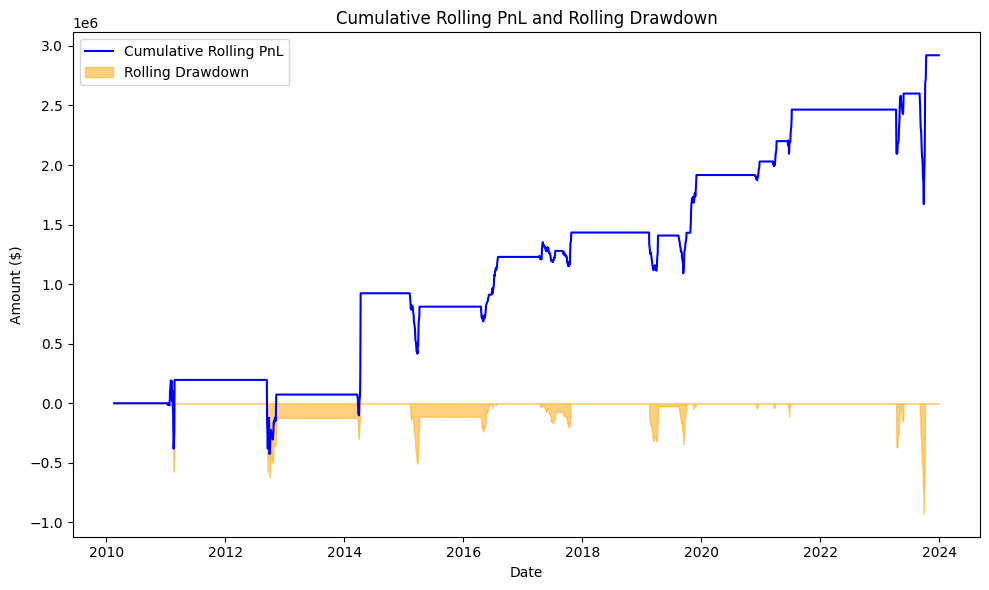

In [64]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import math

# Load fundamental data and the merged price data
fundamental_data = pd.read_csv('fundamental_data.csv')
merged = pd.read_csv('merged.csv', parse_dates=['Date'])

# Preprocess the fundamental data, converting 'Date' to datetime format
fundamental_data['Date'] = pd.to_datetime(fundamental_data['Date'], format='%b %d, %Y')


merged = pd.merge(merged, fundamental_data[['Date',
                                             'Weekly U.S. Ending Stocks excluding SPR of Crude Oil and Petroleum Products  (Thousand Barrels)',
                                             'Weekly Midwest (PADD 2) Ending Stocks excluding SPR of Crude Oil  (Thousand Barrels)']],
                  on='Date', how='left')

# Calculate the percentage change in the inventory columns
merged['US_Inventory_Change'] = merged['Weekly U.S. Ending Stocks excluding SPR of Crude Oil and Petroleum Products  (Thousand Barrels)'].pct_change()
merged['Midwest_Inventory_Change'] = merged['Weekly Midwest (PADD 2) Ending Stocks excluding SPR of Crude Oil  (Thousand Barrels)'].pct_change()

# Create signals based on quantiles for significant changes in inventory
merged['US_Inventory_Signal'] = 0  # Default value
merged['Midwest_Inventory_Signal'] = 0  # Default value

# Quantile-based signal generation: Long if inventory decreases significantly (lowest 20%), Short if inventory increases significantly (highest 20%)
merged.loc[merged['US_Inventory_Change'] < merged['US_Inventory_Change'].quantile(0.2), 'US_Inventory_Signal'] = 1  # Buy Signal
merged.loc[merged['US_Inventory_Change'] > merged['US_Inventory_Change'].quantile(0.8), 'US_Inventory_Signal'] = -1  # Sell Signal

merged.loc[merged['Midwest_Inventory_Change'] < merged['Midwest_Inventory_Change'].quantile(0.2), 'Midwest_Inventory_Signal'] = 1  # Buy Signal
merged.loc[merged['Midwest_Inventory_Change'] > merged['Midwest_Inventory_Change'].quantile(0.8), 'Midwest_Inventory_Signal'] = -1  # Sell Signal

# Forward fill the inventory signals to propagate them throughout the week (and keep the previous value until new value)
merged['US_Inventory_Signal'] = merged['US_Inventory_Signal'].replace(0, np.nan).ffill()  # Replace 0 with NaN and forward fill
merged['Midwest_Inventory_Signal'] = merged['Midwest_Inventory_Signal'].replace(0, np.nan).ffill()  # Replace 0 with NaN and forward fill

# Modify the trading strategy to filter entries based on the new signal
def run_pair_trading_with_inventory_signal(merged, asset1, asset2, beta_window=30, z_window=60, z_threshold=1.5):
    # Dynamically select the columns for asset1 and asset2 (Crude, HO, or RBOB)
    asset1_f1 = f'{asset1}_F1'
    asset2_f1 = f'{asset2}_F1'

    # Engle-Granger Cointegration Test
    pvalue = engle_granger_test(merged[asset1_f1], merged[asset2_f1])
    print(f"Engle-Granger p-value: {pvalue}")

    if pvalue >= 0.05:
        print("Pair not cointegrated. Stop here or try another pair.")
        return
    else:
        print("Pair cointegrated. Proceeding with rolling beta.")

    # Rolling Beta
    merged['Rolling_Beta'] = (
        merged[asset1_f1].rolling(window=beta_window).cov(merged[asset2_f1])
        / merged[asset2_f1].rolling(window=beta_window).var()
    )

    # Compute Spread
    merged['Spread'] = merged[asset1_f1] - merged['Rolling_Beta'] * merged[asset2_f1]

    # Compute Rolling Mean, Std, and Z-score
    merged['Spread_Mean'] = merged['Spread'].rolling(window=z_window).mean()
    merged['Spread_Std'] = merged['Spread'].rolling(window=z_window).std()
    merged['Z_Score'] = (merged['Spread'] - merged['Spread_Mean']) / merged['Spread_Std']

    # Generate Trading Signals: Filter based on Inventory Signal
    merged['Position'] = 0  # Initialize position column

    for i in range(1, len(merged)):
        # Check if the fundamental signal aligns with the position
        if merged['Z_Score'].iloc[i] > z_threshold and merged['US_Inventory_Signal'].iloc[i] == -1:
            merged.at[merged.index[i], 'Position'] = -1  # Short Spread
        elif merged['Z_Score'].iloc[i] < -z_threshold and merged['US_Inventory_Signal'].iloc[i] == 1:
            merged.at[merged.index[i], 'Position'] = 1   # Long Spread
        elif merged['Position'].iloc[i-1] == 1 and merged['Z_Score'].iloc[i] >= 0:
            merged.at[merged.index[i], 'Position'] = 0   # Close Long
        elif merged['Position'].iloc[i-1] == -1 and merged['Z_Score'].iloc[i] <= 0:
            merged.at[merged.index[i], 'Position'] = 0   # Close Short
        else:
            merged.at[merged.index[i], 'Position'] = merged['Position'].iloc[i-1]  # Hold previous position

    scaling_factor = 10 * 1000

    # 8. Calculate PnL (Using Previous Signal to Avoid Bias)
    merged['Spread_Return'] = merged['Spread'].diff()  # Daily change in spread
    merged['Strategy_Return'] = merged['Position'].shift(1) * merged['Spread_Return']  # Previous day's position * today's return

    # Scale the strategy return
    merged['Scaled_Strategy_Return'] = merged['Strategy_Return'] * scaling_factor

    # 9. Compute Cumulative PnL (Using the Scaled Strategy Return)
    merged['Cumulative_PnL'] = merged['Scaled_Strategy_Return'].cumsum()

    # 10. Calculate APL (Annualized PnL)
    total_pnl = merged['Scaled_Strategy_Return'].sum()  # Sum of strategy returns using the scaled return
    days_in_dataset = len(merged)
    APL = total_pnl / (days_in_dataset / 252)  # Annualized PnL

    # 11. Calculate Sharpe Ratio
    daily_std = merged['Strategy_Return'].std()
    global_sharpe_ratio = APL / (daily_std * math.sqrt(250) * scaling_factor)  # Assume 250 trading days in a year

    # Compute Cumulative Rolling PnL using the scaled return
    merged['Rolling_Cumulative_PnL'] = merged['Scaled_Strategy_Return'].cumsum()

    # 12. Calculate Highest Maximum Value of Cumulative PnL (HMW)
    merged['Rolling_HMW'] = merged['Rolling_Cumulative_PnL'].cummax()  # Highest Maximum Value (Cumulative PnL)

    # 13. Calculate Drawdown (DD)
    merged['Rolling_Drawdown'] = merged['Rolling_Cumulative_PnL'] - merged['Rolling_HMW']  # Negative drawdown

    # 14. Calculate Maximum Drawdown (Max DD)
    max_dd = merged['Rolling_Drawdown'].min()  # Minimum of Drawdown column gives Max Drawdown

    # 15. Calculate RoD (Return on Drawdown)
    RoD = APL / abs(max_dd)

    # Display metrics
    metrics = {
        "APL": APL,
        "Sharpe Ratio": global_sharpe_ratio,
        "Max Drawdown": max_dd,
        "RoD": RoD
    }

    print("Performance Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    # Plotting the Cumulative PnL and Rolling Drawdown
    plt.figure(figsize=(10, 6))

    # Plot Cumulative PnL
    plt.plot(merged['Date'], merged['Rolling_Cumulative_PnL'], label='Cumulative Rolling PnL', color='blue')

    # Plot Rolling Drawdown
    plt.fill_between(merged['Date'], merged['Rolling_Drawdown'], color='orange', alpha=0.5, label='Rolling Drawdown')

    # Add labels and title
    plt.title('Cumulative Rolling PnL and Rolling Drawdown')
    plt.xlabel('Date')
    plt.ylabel('Amount ($)')
    plt.legend(loc='upper left')

    # Show the plot
    plt.tight_layout()
    plt.show()


    return merged

# Running the strategy with the new inventory filter
merged = run_pair_trading_with_inventory_signal(merged, asset1='Crude', asset2='RBOB', beta_window=30, z_window=60, z_threshold=2.5)


# Only Midwest_Inventory_Signal

<ipython-input-66-aac99e12b3f0>:21: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  merged['US_Inventory_Change'] = merged['Weekly U.S. Ending Stocks excluding SPR of Crude Oil and Petroleum Products  (Thousand Barrels)'].pct_change()
<ipython-input-66-aac99e12b3f0>:22: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  merged['Midwest_Inventory_Change'] = merged['Weekly Midwest (PADD 2) Ending Stocks excluding SPR of Crude Oil  (Thousand Barrels)'].pct_change()


Engle-Granger p-value: 7.771103183303982e-06
Pair cointegrated. Proceeding with rolling beta.
Performance Metrics:
APL: 259141.9127
Sharpe Ratio: 0.9021
Max Drawdown: -646454.2065
RoD: 0.4009


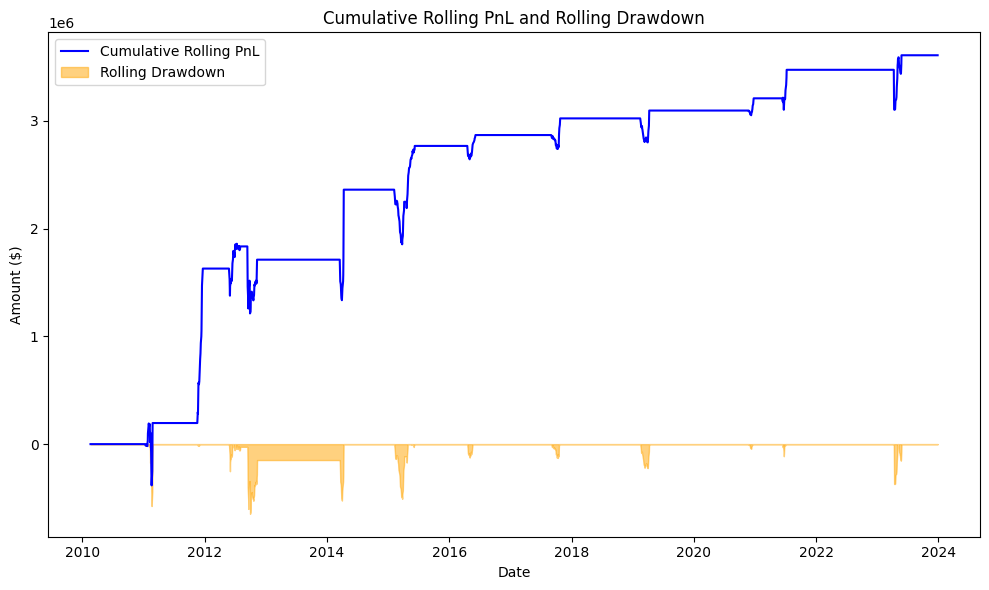

In [66]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import math

# Load fundamental data and the merged price data
fundamental_data = pd.read_csv('fundamental_data.csv')
merged = pd.read_csv('merged.csv', parse_dates=['Date'])

# Preprocess the fundamental data, converting 'Date' to datetime format
fundamental_data['Date'] = pd.to_datetime(fundamental_data['Date'], format='%b %d, %Y')


merged = pd.merge(merged, fundamental_data[['Date',
                                             'Weekly U.S. Ending Stocks excluding SPR of Crude Oil and Petroleum Products  (Thousand Barrels)',
                                             'Weekly Midwest (PADD 2) Ending Stocks excluding SPR of Crude Oil  (Thousand Barrels)']],
                  on='Date', how='left')

# Calculate the percentage change in the inventory columns
merged['US_Inventory_Change'] = merged['Weekly U.S. Ending Stocks excluding SPR of Crude Oil and Petroleum Products  (Thousand Barrels)'].pct_change()
merged['Midwest_Inventory_Change'] = merged['Weekly Midwest (PADD 2) Ending Stocks excluding SPR of Crude Oil  (Thousand Barrels)'].pct_change()

# Create signals based on quantiles for significant changes in inventory
merged['US_Inventory_Signal'] = 0  # Default value
merged['Midwest_Inventory_Signal'] = 0  # Default value

# Quantile-based signal generation: Long if inventory decreases significantly (lowest 20%), Short if inventory increases significantly (highest 20%)
merged.loc[merged['US_Inventory_Change'] < merged['US_Inventory_Change'].quantile(0.2), 'US_Inventory_Signal'] = 1  # Buy Signal
merged.loc[merged['US_Inventory_Change'] > merged['US_Inventory_Change'].quantile(0.8), 'US_Inventory_Signal'] = -1  # Sell Signal

merged.loc[merged['Midwest_Inventory_Change'] < merged['Midwest_Inventory_Change'].quantile(0.2), 'Midwest_Inventory_Signal'] = 1  # Buy Signal
merged.loc[merged['Midwest_Inventory_Change'] > merged['Midwest_Inventory_Change'].quantile(0.8), 'Midwest_Inventory_Signal'] = -1  # Sell Signal

# Forward fill the inventory signals to propagate them throughout the week (and keep the previous value until new value)
merged['US_Inventory_Signal'] = merged['US_Inventory_Signal'].replace(0, np.nan).ffill()  # Replace 0 with NaN and forward fill
merged['Midwest_Inventory_Signal'] = merged['Midwest_Inventory_Signal'].replace(0, np.nan).ffill()  # Replace 0 with NaN and forward fill

# Modify the trading strategy to filter entries based on the new signal
def run_pair_trading_with_inventory_signal(merged, asset1, asset2, beta_window=30, z_window=60, z_threshold=1.5):
    # Dynamically select the columns for asset1 and asset2 (Crude, HO, or RBOB)
    asset1_f1 = f'{asset1}_F1'
    asset2_f1 = f'{asset2}_F1'

    # Engle-Granger Cointegration Test
    pvalue = engle_granger_test(merged[asset1_f1], merged[asset2_f1])
    print(f"Engle-Granger p-value: {pvalue}")

    if pvalue >= 0.05:
        print("Pair not cointegrated. Stop here or try another pair.")
        return
    else:
        print("Pair cointegrated. Proceeding with rolling beta.")

    # Rolling Beta
    merged['Rolling_Beta'] = (
        merged[asset1_f1].rolling(window=beta_window).cov(merged[asset2_f1])
        / merged[asset2_f1].rolling(window=beta_window).var()
    )

    # Compute Spread
    merged['Spread'] = merged[asset1_f1] - merged['Rolling_Beta'] * merged[asset2_f1]

    # Compute Rolling Mean, Std, and Z-score
    merged['Spread_Mean'] = merged['Spread'].rolling(window=z_window).mean()
    merged['Spread_Std'] = merged['Spread'].rolling(window=z_window).std()
    merged['Z_Score'] = (merged['Spread'] - merged['Spread_Mean']) / merged['Spread_Std']

    # Generate Trading Signals: Filter based on Inventory Signal
    merged['Position'] = 0  # Initialize position column

    for i in range(1, len(merged)):
        # Check if the fundamental signal aligns with the position
        if merged['Z_Score'].iloc[i] > z_threshold and merged['Midwest_Inventory_Signal'].iloc[i] == -1:
            merged.at[merged.index[i], 'Position'] = -1  # Short Spread
        elif merged['Z_Score'].iloc[i] < -z_threshold and merged['Midwest_Inventory_Signal'].iloc[i] == 1:
            merged.at[merged.index[i], 'Position'] = 1   # Long Spread
        elif merged['Position'].iloc[i-1] == 1 and merged['Z_Score'].iloc[i] >= 0:
            merged.at[merged.index[i], 'Position'] = 0   # Close Long
        elif merged['Position'].iloc[i-1] == -1 and merged['Z_Score'].iloc[i] <= 0:
            merged.at[merged.index[i], 'Position'] = 0   # Close Short
        else:
            merged.at[merged.index[i], 'Position'] = merged['Position'].iloc[i-1]  # Hold previous position

    scaling_factor = 10 * 1000

    # 8. Calculate PnL (Using Previous Signal to Avoid Bias)
    merged['Spread_Return'] = merged['Spread'].diff()  # Daily change in spread
    merged['Strategy_Return'] = merged['Position'].shift(1) * merged['Spread_Return']  # Previous day's position * today's return

    # Scale the strategy return
    merged['Scaled_Strategy_Return'] = merged['Strategy_Return'] * scaling_factor

    # 9. Compute Cumulative PnL (Using the Scaled Strategy Return)
    merged['Cumulative_PnL'] = merged['Scaled_Strategy_Return'].cumsum()

    # 10. Calculate APL (Annualized PnL)
    total_pnl = merged['Scaled_Strategy_Return'].sum()  # Sum of strategy returns using the scaled return
    days_in_dataset = len(merged)
    APL = total_pnl / (days_in_dataset / 252)  # Annualized PnL

    # 11. Calculate Sharpe Ratio
    daily_std = merged['Strategy_Return'].std()
    global_sharpe_ratio = APL / (daily_std * math.sqrt(250) * scaling_factor)  # Assume 250 trading days in a year

    # Compute Cumulative Rolling PnL using the scaled return
    merged['Rolling_Cumulative_PnL'] = merged['Scaled_Strategy_Return'].cumsum()

    # 12. Calculate Highest Maximum Value of Cumulative PnL (HMW)
    merged['Rolling_HMW'] = merged['Rolling_Cumulative_PnL'].cummax()  # Highest Maximum Value (Cumulative PnL)

    # 13. Calculate Drawdown (DD)
    merged['Rolling_Drawdown'] = merged['Rolling_Cumulative_PnL'] - merged['Rolling_HMW']  # Negative drawdown

    # 14. Calculate Maximum Drawdown (Max DD)
    max_dd = merged['Rolling_Drawdown'].min()  # Minimum of Drawdown column gives Max Drawdown

    # 15. Calculate RoD (Return on Drawdown)
    RoD = APL / abs(max_dd)

    # Display metrics
    metrics = {
        "APL": APL,
        "Sharpe Ratio": global_sharpe_ratio,
        "Max Drawdown": max_dd,
        "RoD": RoD
    }

    print("Performance Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    # Plotting the Cumulative PnL and Rolling Drawdown
    plt.figure(figsize=(10, 6))

    # Plot Cumulative PnL
    plt.plot(merged['Date'], merged['Rolling_Cumulative_PnL'], label='Cumulative Rolling PnL', color='blue')

    # Plot Rolling Drawdown
    plt.fill_between(merged['Date'], merged['Rolling_Drawdown'], color='orange', alpha=0.5, label='Rolling Drawdown')

    # Add labels and title
    plt.title('Cumulative Rolling PnL and Rolling Drawdown')
    plt.xlabel('Date')
    plt.ylabel('Amount ($)')
    plt.legend(loc='upper left')

    # Show the plot
    plt.tight_layout()
    plt.show()


    return merged

# Running the strategy with the new inventory filter
merged = run_pair_trading_with_inventory_signal(merged, asset1='Crude', asset2='RBOB', beta_window=30, z_window=60, z_threshold=2.5)
